# Librerias

In [1]:
import pandas as pd
#from hmmlearn import hmm
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
import matplotlib.pyplot as plt
#from hmmlearn.hmm import GMMHMM
from  sklearn.metrics import mean_squared_error as mse
from sklearn.utils import class_weight
from astropy.io import fits
import matplotlib.pyplot as plt
import os, sys

from sklearn.metrics import confusion_matrix,accuracy_score
from keras.regularizers import l2
from keras.activations import tanh
from keras.models import Sequential
from keras.layers import *
from keras.losses import categorical_crossentropy,binary_crossentropy
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from keras import backend as K
from time import time
from random import shuffle,seed
from sklearn.metrics import classification_report
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from keras.backend import eval

Using TensorFlow backend.


# Funciones

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score,f1_score, confusion_matrix, mean_absolute_error,mean_squared_error, median_absolute_error
from sklearn.preprocessing import normalize
import time
import matplotlib.pyplot as plt

def plot_df(df):
    try:
        from IPython.display import display
        display(df)
    except:
        print(df)
    
def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=1.0)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
def calculate_metrics(y_true,y_pred,plot=True, title=""):
    dic_return = {}
    dic_return["Precision raw"] = precision_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["Recall raw"] = recall_score(y_true,y_pred,average=None,labels=[0,1])
    #dic_return["Precision"] = precision_score(y_true,y_pred,average=None,labels=[0,1])
    #dic_return["Recall"] = recall_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["F1 raw"] = f1_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["F1 weighted"] = f1_score(y_true,y_pred,average="weighted",labels=[0,1])
    dic_return["F1 macro"] = f1_score(y_true,y_pred,average="macro",labels=[0,1])
    dic_return["F1 micro"] = f1_score(y_true,y_pred,average="micro",labels=[0,1])
    matriz=confusion_matrix(y_true,y_pred, labels=[0,1])
    if plot:
        df = pd.DataFrame(dic_return)
        df.index = ["False Positive","Confirmed"]
        plot_df(df)
        plot_confusion_matrix(normalize(matriz,axis=1,norm='l1'),["False Positive","Confirmed"],title)
    dic_return["Confusion Matrix"] = matriz
    return dic_return


def calculate_median_abs_err(real, pred): 
    if len(real.shape) > 1:
        return np.mean([median_absolute_error(real[:,d],pred[:,d]) for d in range(real.shape[1])])   
    else:
        return median_absolute_error(real,pred)
    
def calculate_mean_abs_perce_err(real, pred):
    diff = np.abs((real - pred) / np.clip(np.abs(real), 1e-7, None))
    return 100. * np.mean(diff) #sin *100 es "fractional"

def calculate_Rmean_squar_log_err(real, pred):
    first_log = np.log(np.clip(pred, 1e-7, None) + 1.)
    second_log = np.log(np.clip(real, 1e-7, None) + 1.)
    return np.sqrt(np.mean(np.square(first_log - second_log)))

def evaluate_metadata(real, pred, plot=False):
    dic_res = {}
    dic_res["MSE"] = mean_squared_error(real, pred)
    dic_res["MAE"] = mean_absolute_error(real, pred)
    dic_res["MeAE"] = calculate_median_abs_err(real, pred)
    dic_res["MApE"] = calculate_mean_abs_perce_err(real,pred)
    dic_res["RMSLE"] = calculate_Rmean_squar_log_err(real,pred)
    if plot:
        df = pd.DataFrame(dic_res)
        df.index = ["Real"]
        plot_df(df)
    return dic_res

def evaluate_metadata_raw(real, pred, plot=True, metadata_used=[""]):
    mse_raw = []
    mae_raw = []
    mEae_raw = []
    maPe_raw = []
    rmsle_raw = []
    for d in range(real.shape[1]):        
        dic_aux = evaluate_metadata(real[:,d], pred[:,d], plot=False)
        mse_raw.append(dic_aux["MSE"])
        mae_raw.append(dic_aux["MAE"])
        mEae_raw.append(dic_aux["MeAE"])
        maPe_raw.append(dic_aux["MApE"])
        rmsle_raw.append(dic_aux["RMSLE"])
        
    res_metadata = {}
    res_metadata["MSE"] = mse_raw
    res_metadata["MAE"] = mae_raw
    res_metadata["MeAE"] = mEae_raw
    res_metadata["MApE"] = maPe_raw
    res_metadata["RMSLE"] = rmsle_raw
    
    if plot:
        df = pd.DataFrame(res_metadata)
        df.index = metadata_used
        df.loc["Global"] = np.mean(df, axis=0)
        plot_df(df.transpose())
    res_metadata["MSE"].append(np.mean(mse_raw))
    res_metadata["MAE"].append(np.mean(mae_raw))
    res_metadata["MeAE"].append(np.mean(mEae_raw))
    res_metadata["MApE"].append(np.mean(maPe_raw))
    res_metadata["RMSLE"].append(np.mean(rmsle_raw))
    return res_metadata




def train_model(aux_model, x_train, y_train, x_val, y_val, e=25, BS=128):
    hist=aux_model.fit(x_train, y_train, batch_size=BS, epochs=e, verbose=1, validation_data=(x_val,y_val))
    plt.plot(hist.history['loss'],label="train_loss")
    plt.plot(hist.history['val_loss'],label="val_loss")
    plt.title("Model Loss BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    plt.plot(hist.history['acc'],label="Train accuracy" )
    plt.plot(hist.history['val_acc'],label="Val accuracy" )
    plt.title("Model Accuracy BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    predichos=aux_model.predict_classes(x_val)
    calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')


# Cargar datos

## Generar imagenes con 3 canales

In [3]:
df_aux = pd.read_csv("../../KOI_Data/kepler_dataset.csv")
labels = (df_aux["NExScI Disposition"] == "CONFIRMED").values*1
labels.shape

(8054,)

In [4]:
channel_1 = np.load('/work/work_teamEXOPLANET/MTF_margarita/no_invertidos/MTF_u64_d64.npy')  
channel_2 = np.load('/work/work_teamEXOPLANET/MTF_margarita/invertidos/MTF_u64_d64.npy')  
channel_3 = np.load('/work/work_teamEXOPLANET/MTF_gabo/npys/MTF_time_u64_d64.npy')  

In [5]:
print(channel_1.shape)
print(channel_2.shape)
print(channel_3.shape)

(8054, 128, 128)
(8054, 128, 128)
(8054, 128, 128)


###### 3 canales

In [6]:
x_all = []
for i in range(channel_1.shape[0]):
    combined_image = np.dstack((channel_1[i],channel_2[i],channel_3[i]))
    x_all.append(combined_image)
x_all = np.asarray(x_all)

###### 2 canales (sin tiempo)

In [7]:
'''x_all = []
for i in range(channel_1.shape[0]):
    combined_image = np.dstack((channel_1[i],channel_2[i]))
    x_all.append(combined_image)
x_all = np.asarray(x_all)'''

'x_all = []\nfor i in range(channel_1.shape[0]):\n    combined_image = np.dstack((channel_1[i],channel_2[i]))\n    x_all.append(combined_image)\nx_all = np.asarray(x_all)'

###### 2 canales (marvko -> + tiempo)

In [54]:
x_all = []
for i in range(channel_1.shape[0]):
    combined_image = np.dstack((channel_1[i],channel_3[i]))
    x_all.append(combined_image)
x_all = np.asarray(x_all)

###### 2 canales (arriba) + data augm

In [6]:
x_all = []
for i in range(channel_1.shape[0]):
    combined_image = np.dstack((channel_1[i],channel_3[i]))
    x_all.append(combined_image)
x_all = np.asarray(x_all)

x_all2 = []
for i in range(channel_1.shape[0]):
    combined_image = np.dstack((channel_2[i],channel_3[i]))
    x_all2.append(combined_image)
x_all2 = np.asarray(x_all2)

In [7]:
x_all.shape

(8054, 128, 128, 2)

## Generar conjunto de entrenamiento y validación

In [8]:
fold = "../../KOI_Data/"
df_sets = pd.read_csv(fold+"/koi_sets.csv") 
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
mask_unlabeled = (df_sets["Set"] == "Unlabeled").values
df_sets.head()

KOI Name        Set
0  K00889.01      Train
1  K01009.01      Train
2  K07621.01       Test
3  K06252.01       Test
4  K00958.01  Unlabeled

In [9]:
df_meta = pd.read_csv(fold+"/koi_metadata.csv")
df_meta_train = df_meta[mask_train]
df_meta_test = df_meta[mask_test]
df_meta_unb = df_meta[mask_unlabeled]

df_meta_train.head()

KOI Name NExScI Disposition   Kepler Name      Period  \
0   K00889.01          CONFIRMED   Kepler-75 b    8.884923   
1   K01009.01     FALSE POSITIVE           NaN    5.092465   
7   K07622.01     FALSE POSITIVE           NaN   36.267167   
9   K00998.01     FALSE POSITIVE           NaN  161.788327   
10  K00992.01          CONFIRMED  Kepler-745 b    9.931463   

    Time of Transit Epoch  First Transit Time (BJD)  Impact Parameter  \
0              169.991686               2455002.992             0.069   
1              357.535940               2455190.536             0.161   
7              155.081300               2454988.081             0.214   
9              214.039000               2455047.039             0.267   
10             136.491280               2454969.491             0.037   

    Duration  Transit Depth    r/R  ...    Teff  log(g)  Metallicity  \
0    2.07004        16053.4  0.114  ...  5332.0   4.500        -0.08   
1    3.65900          254.0  0.014  ...  5037.0   4.547        -0.20   
7    2.06500          627.1  0.022  ...  4264.0   4.637        -0.20   
9    5.31000        87750.0  0.273  ...  6018.0   4.327         0.18   
10   5.67800          398.6  0.018  ...  5782.0   4.280         0.16   

    Stellar Radius  Stellar Mass  Max single event sigma  \
0            0.843         0.821                  61.291   
1            0.751         0.727                   3.648   
7            0.620         0.607                   3.016   
9            1.212         1.142                 341.666   
10           1.220         1.035                   4.530   

    Max Multievent sigma  Transit Model SNR  KOI count  Transit Number  
0                474.021              388.2          1             153  
1                 15.175               17.1          1             225  
7                  7.472               10.0          1              39  
9                806.993              704.5          1               9  
10                22.901               26.2          2             137  

[5 rows x 31 columns]

In [10]:
y_train= (df_meta_train['NExScI Disposition'].values=="CONFIRMED")*1
y_val = (df_meta_test['NExScI Disposition'].values=="CONFIRMED")*1

unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_val, counts_val = np.unique(y_val, return_counts=True)

print('y_train distribution: 0:%i   1:%i'%(counts_train[0],counts_train[1]))
print('y_val distribution:   0:%i   1:%i'%(counts_val[0],counts_val[1]))

y_train distribution: 0:2729   1:1610
y_val distribution:   0:1247   1:671


In [11]:
x_train = x_all[mask_train]
x_val = x_all[mask_test]

if x_train.shape[0] < y_train.shape[0]:
    y_train = y_train[:x_train.shape[0]]
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

Objetos de entrenamiento: (4339, 128, 128, 2) (4339,)
Objetos de validación: (1918, 128, 128, 2) (1918,)


###### 2 canales (arriba) + data augm

In [12]:
x_train1 = x_all[mask_train]
x_train2 = x_all2[mask_train]
x_train = np.concatenate([x_train1,x_train2]) #concat

x_val = x_all[mask_test]

if x_train.shape[0] != y_train.shape[0]:
    y_train = np.tile(y_train, (2))
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

Objetos de entrenamiento: (8678, 128, 128, 2) (8678,)
Objetos de validación: (1918, 128, 128, 2) (1918,)


## Pruebas CNN utilizando loss = binary_crossentropy

In [13]:
model = Sequential()
model.add(Flatten(input_shape=x_train.shape[1:]))
model.add(Dense(256, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1800)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               461056    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 462,337
Trainable params: 461,825
Non-trainable params: 512
___________________________________________________________

Train on 8678 samples, validate on 1918 samples
Epoch 1/25
8678/8678 [==============================] - 2s 225us/step - loss: 0.6558 - acc: 0.6321 - val_loss: 3.4765 - val_acc: 0.3592
Epoch 2/25
8678/8678 [==============================] - 1s 81us/step - loss: 0.5567 - acc: 0.6826 - val_loss: 0.5375 - val_acc: 0.6960
Epoch 3/25
8678/8678 [==============================] - 1s 80us/step - loss: 0.5399 - acc: 0.6911 - val_loss: 1.8074 - val_acc: 0.5115
Epoch 4/25
8678/8678 [==============================] - 1s 81us/step - loss: 0.5261 - acc: 0.7045 - val_loss: 1.9789 - val_acc: 0.5209
Epoch 5/25
8678/8678 [==============================] - 1s 80us/step - loss: 0.5162 - acc: 0.7081 - val_loss: 1.8630 - val_acc: 0.5308
Epoch 6/25
8678/8678 [==============================] - 1s 82us/step - loss: 0.5028 - acc: 0.7171 - val_loss: 0.6152 - val_acc: 0.6861
Epoch 7/25
8678/8678 [==============================] - 1s 84us/step - loss: 0.5086 - acc: 0.7138 - val_loss: 0.8686 - val_acc: 0.5897
Epoch 

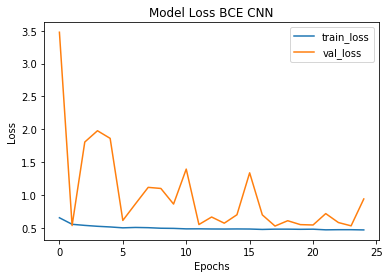

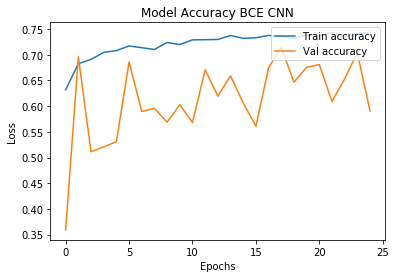

In [14]:
hist=model.fit(x_train, y_train, batch_size=128, epochs=25, verbose=1, validation_data=(x_val,y_val))

plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist.history['acc'],label="Train accuracy" )
plt.plot(hist.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

### Experimentos FMEna - f1 score

In [13]:
import keras
from keras.callbacks import Callback,ModelCheckpoint, ReduceLROnPlateau
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []

    def on_epoch_end(self, batch, logs={}):
        predict = np.squeeze(self.model.predict_classes(self.validation_data[0]))
        targ = np.squeeze(self.validation_data[1])
        f1s = f1_score(targ, predict, average='macro')
        self.val_f1s.append(f1s)
        print(" - val_f1: %f " %(f1s))
        return

import tensorflow as tf
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

def train_model(aux_model, x_train, y_train, x_val, y_val, e=25, BS=128, focal=False,alpha=0.6,save_f='best_mod.hdf5'):
    if focal:
        aux_model.compile(loss=binary_focal_loss(alpha=alpha, gamma=2),optimizer='Adam',metrics=['accuracy'])
    else:
        aux_model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
    
    calls = []
    metrics = Metrics()
    calls.append(metrics)
    mcp_save = ModelCheckpoint(save_f, save_best_only=True, monitor='val_loss', mode='min')
    calls.append(mcp_save)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode ='min',factor=0.2,patience=10, min_lr=0.001)
    if not focal:
        calls.append(reduce_lr)
    hist=aux_model.fit(x_train, y_train, batch_size=BS, epochs=e, verbose=1, validation_split=0.1,#validation_data=(x_val,y_val),
                      callbacks=calls)
    
    plt.figure(figsize=(12,5))
    plt.plot(hist.history['loss'],label="train_loss")
    plt.plot(hist.history['val_loss'],label="val_loss")
    plt.title("Model Loss BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    plt.figure(figsize=(12,5))
    plt.plot(hist.history['acc'],label="Train accuracy" )
    plt.plot(hist.history['val_acc'],label="Val accuracy" )
    plt.title("Model Accuracy BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()
    
    plt.figure(figsize=(12,5))
    if not focal:
        plt.plot(hist.history['val_loss'],label="loss" )
    plt.plot(hist.history['val_acc'],label="accuracy" )
    plt.plot(metrics.val_f1s,label="F1" )
    plt.ylabel("Metric")
    plt.xlabel('Epochs')
    plt.title("Test set/val")
    plt.legend(loc="upper left")
    plt.show()
    
    
    #print("Best f1 macro trough iters %f on %d "%(np.max(metrics.val_f1s),np.argmax(metrics.val_f1s)))

    #predichos=aux_model.predict_classes(x_val)
    #calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')

## Modificaciones
* guarda el mejor modelo (pesos) en base a val loss random (10%)

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

Train on 7810 samples, validate on 868 samples
Epoch 1/200
7680/7810 [============================>.] - ETA: 0s - loss: 0.6559 - acc: 0.6348

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 - val_f1: 0.350785 
7810/7810 [==============================] - 20s 3ms/step - loss: 0.6555 - acc: 0.6344 - val_loss: 0.6646 - val_acc: 0.5403
Epoch 2/200
7810/7810 [==============================] - 18s 2ms/step - loss: 0.5787 - acc: 0.6346 - val_loss: 0.6063 - val_acc: 0.5403
Epoch 3/200
7810/7810 [==============================] - 17s 2ms/step - loss: 0.5614 - acc: 0.6387 - val_loss: 0.6008 - val_acc: 0.5403
Epoch 4/200
7810/7810 [==============================] - 15s 2ms/step - loss: 0.5597 - acc: 0.6391 - val_loss: 0.5998 - val_acc: 0.5403
Epoch 5/200
7810/7810 [==============================] - 19s 2ms/step - loss: 0.5523 - acc: 0.6389 - val_loss: 0.5939 - val_acc: 0.5403
Epoch 6/200
7810/7810 [==============================] - 18s 2ms/step - loss: 0.5502 - acc: 0.6366 - val_loss: 0.5831 - val_acc: 0.5403
Epoch 7/200
7810/7810 [==============================] - 17s 2ms/step - loss: 0.5418 - acc: 0.6382 - val_loss: 0.5724 - val_acc: 0.5484
Epoch 8/200
7810/7810 [================

Epoch 36/200
7810/7810 [==============================] - 17s 2ms/step - loss: 0.4686 - acc: 0.7446 - val_loss: 0.4806 - val_acc: 0.7200
Epoch 37/200
7810/7810 [==============================] - 17s 2ms/step - loss: 0.4738 - acc: 0.7378 - val_loss: 0.4948 - val_acc: 0.6959
Epoch 38/200
7810/7810 [==============================] - 18s 2ms/step - loss: 0.4738 - acc: 0.7364 - val_loss: 0.4997 - val_acc: 0.6866
Epoch 39/200
7810/7810 [==============================] - 17s 2ms/step - loss: 0.4662 - acc: 0.7456 - val_loss: 0.5039 - val_acc: 0.6843
Epoch 40/200
7810/7810 [==============================] - 17s 2ms/step - loss: 0.4654 - acc: 0.7424 - val_loss: 0.4893 - val_acc: 0.7005
Epoch 41/200
7810/7810 [==============================] - 17s 2ms/step - loss: 0.4652 - acc: 0.7481 - val_loss: 0.4633 - val_acc: 0.7362
Epoch 42/200
7810/7810 [==============================] - 17s 2ms/step - loss: 0.4599 - acc: 0.7503 - val_loss: 0.4810 - val_acc: 0.7085
Epoch 43/200
7810/7810 [=================

7810/7810 [==============================] - 18s 2ms/step - loss: 0.3719 - acc: 0.8051 - val_loss: 0.4033 - val_acc: 0.7800
Epoch 105/200
7810/7810 [==============================] - 17s 2ms/step - loss: 0.3821 - acc: 0.8008 - val_loss: 0.4318 - val_acc: 0.7558
Epoch 106/200
7810/7810 [==============================] - 18s 2ms/step - loss: 0.3735 - acc: 0.8086 - val_loss: 0.4620 - val_acc: 0.7293
Epoch 107/200
7810/7810 [==============================] - 18s 2ms/step - loss: 0.3735 - acc: 0.8074 - val_loss: 0.4269 - val_acc: 0.7512
Epoch 108/200
7810/7810 [==============================] - 17s 2ms/step - loss: 0.3732 - acc: 0.8055 - val_loss: 0.4118 - val_acc: 0.7742
Epoch 109/200
7810/7810 [==============================] - 18s 2ms/step - loss: 0.3707 - acc: 0.8132 - val_loss: 0.4100 - val_acc: 0.7869
Epoch 110/200
7810/7810 [==============================] - 18s 2ms/step - loss: 0.3705 - acc: 0.8143 - val_loss: 0.4342 - val_acc: 0.7558
Epoch 111/200
7810/7810 [=======================

7810/7810 [==============================] - 16s 2ms/step - loss: 0.2800 - acc: 0.8649 - val_loss: 0.4274 - val_acc: 0.7765
Epoch 173/200
7810/7810 [==============================] - 17s 2ms/step - loss: 0.2782 - acc: 0.8662 - val_loss: 0.4330 - val_acc: 0.7776
Epoch 174/200
7810/7810 [==============================] - 18s 2ms/step - loss: 0.2735 - acc: 0.8729 - val_loss: 0.4194 - val_acc: 0.7823
Epoch 175/200
7810/7810 [==============================] - 15s 2ms/step - loss: 0.2731 - acc: 0.8708 - val_loss: 0.4445 - val_acc: 0.7753
Epoch 176/200
7810/7810 [==============================] - 17s 2ms/step - loss: 0.2725 - acc: 0.8729 - val_loss: 0.4318 - val_acc: 0.7823
Epoch 177/200
7810/7810 [==============================] - 18s 2ms/step - loss: 0.2713 - acc: 0.8746 - val_loss: 0.4391 - val_acc: 0.7707
Epoch 178/200
7810/7810 [==============================] - 16s 2ms/step - loss: 0.2722 - acc: 0.8711 - val_loss: 0.4388 - val_acc: 0.7765
Epoch 179/200
7810/7810 [=======================

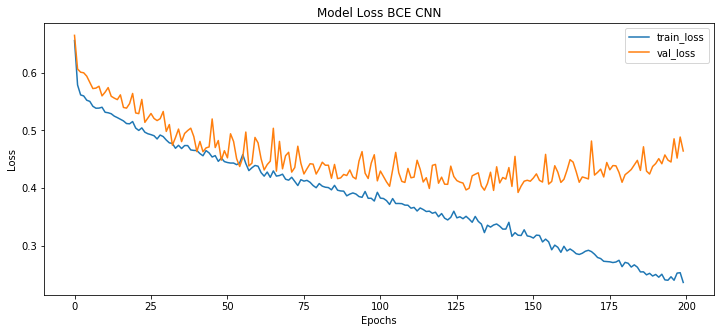

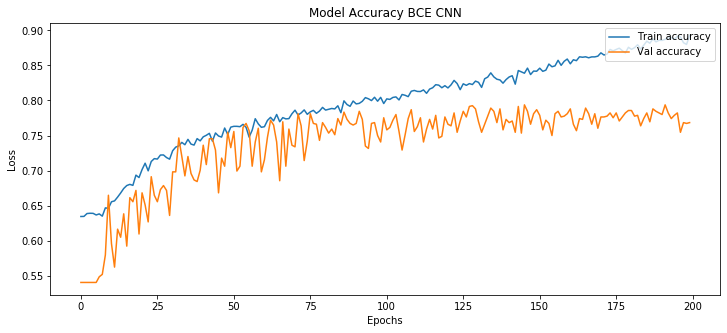

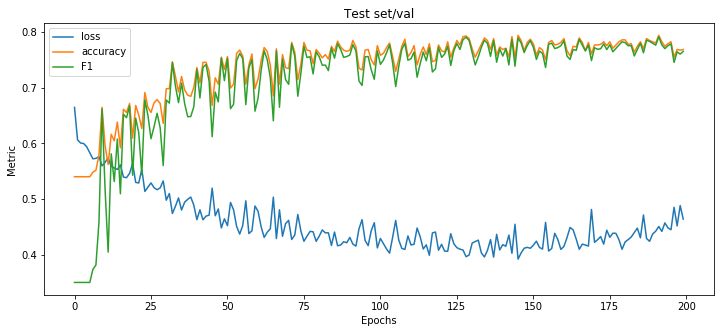

In [18]:
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128*2)  #save model

### 32x32

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 30, 30, 32)        608       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)              0         
__________

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.828346    0.843625  0.835916     0.783778    0.7614   
Confirmed            0.699074    0.675112  0.686884     0.783778    0.7614   

                F1 micro  
False Positive  0.784672  
Confirmed       0.784672

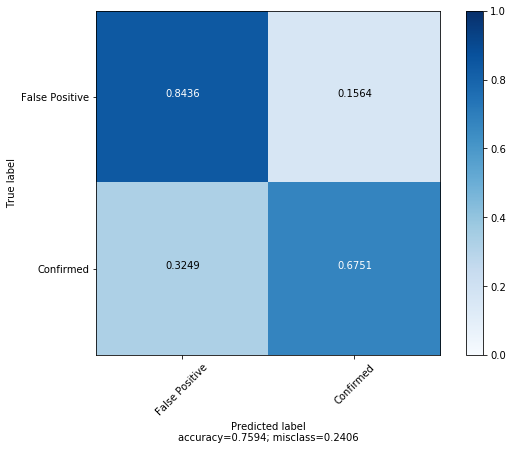

{'Precision raw': array([0.82834646, 0.69907407]),
 'Recall raw': array([0.8436247 , 0.67511177]),
 'F1 raw': array([0.83591577, 0.686884  ]),
 'F1 weighted': 0.7837779638416599,
 'F1 macro': 0.7613998878889661,
 'F1 micro': 0.7846715328467153,
 'Confusion Matrix': array([[1052,  195],
        [ 218,  453]])}

In [30]:
model = keras.models.load_model("best_mod.hdf5")
model.summary()

predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #con 3 capas aumentando/double

### 64x64

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 126, 126, 32)      608       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 12, 12, 32)        9248      
__________

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.855864     0.76664  0.808799     0.768264  0.750867   
Confirmed            0.636704     0.76006  0.692935     0.768264  0.750867   

                F1 micro  
False Positive  0.764338  
Confirmed       0.764338

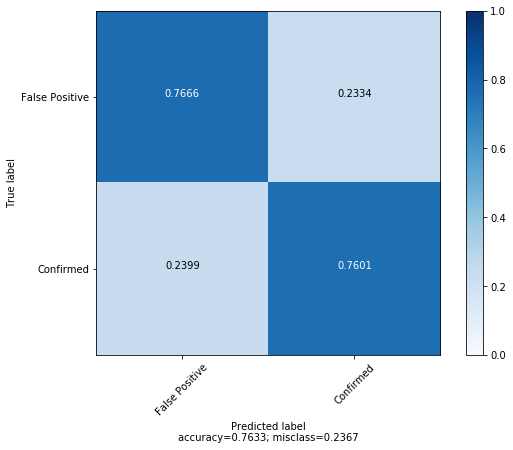

{'Precision raw': array([0.85586392, 0.63670412]),
 'Recall raw': array([0.76663994, 0.76005961]),
 'F1 raw': array([0.80879865, 0.69293478]),
 'F1 weighted': 0.7682644166548337,
 'F1 macro': 0.7508667144853969,
 'F1 micro': 0.7643378519290928,
 'Confusion Matrix': array([[956, 291],
        [161, 510]])}

In [43]:
model = keras.models.load_model("best_mod.hdf5") #normal
model.summary()

predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #con 3 capas aumentando/double

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 126, 126, 32)      608       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 12, 12, 64)        36928     
__________

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.850655    0.781075  0.814381     0.771749  0.753451   
Confirmed            0.646831    0.745156  0.692521     0.771749  0.753451   

                F1 micro  
False Positive  0.768509  
Confirmed       0.768509

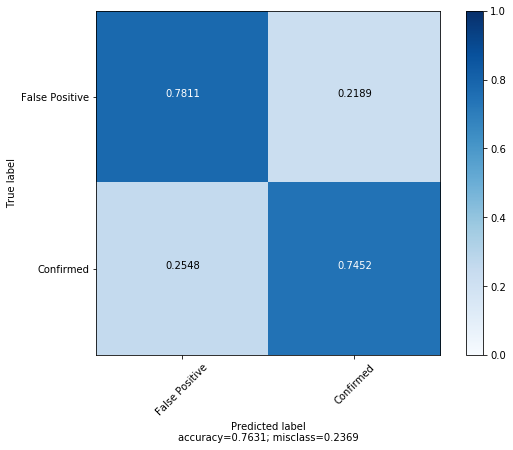

{'Precision raw': array([0.85065502, 0.64683053]),
 'Recall raw': array([0.78107458, 0.74515648]),
 'F1 raw': array([0.81438127, 0.69252078]),
 'F1 weighted': 0.771749158112235,
 'F1 macro': 0.7534510232631393,
 'F1 micro': 0.7685088633993743,
 'Confusion Matrix': array([[974, 273],
        [171, 500]])}

In [46]:
model = keras.models.load_model("best_mod.hdf5") #con 4 capas (32 y luego 64)
model.summary()

predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #con 3 capas aumentando/double

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 126, 126, 32)      608       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
__________

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.838762    0.825982  0.832323     0.784309    0.7637   
Confirmed            0.685507    0.704918  0.695077     0.784309    0.7637   

                F1 micro  
False Positive  0.783629  
Confirmed       0.783629

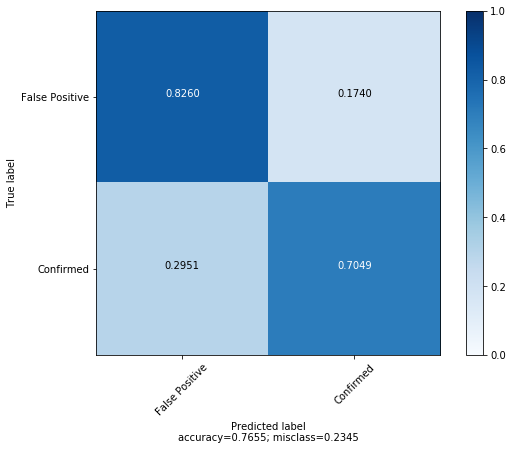

{'Precision raw': array([0.83876221, 0.68550725]),
 'Recall raw': array([0.82598236, 0.70491803]),
 'F1 raw': array([0.83232323, 0.69507715]),
 'F1 weighted': 0.7843085702763806,
 'F1 macro': 0.7637001907391328,
 'F1 micro': 0.7836287799791449,
 'Confusion Matrix': array([[1030,  217],
        [ 198,  473]])}

In [19]:
model = keras.models.load_model("best_mod.hdf5") #con 4 capas (32 y luego 64) con dropa al final
model.summary()

predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #con 3 capas aumentando/double






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      608       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 30, 32)        0         
______________________

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 2/200
7810/7810 [==============================] - 37s 5ms/step - loss: 0.5944 - acc: 0.6338 - val_loss: 0.6033 - val_acc: 0.5403
Epoch 3/200
7810/7810 [==============================] - 41s 5ms/step - loss: 0.5652 - acc: 0.6405 - val_loss: 0.5992 - val_acc: 0.5415
Epoch 4/200
7810/7810 [==============================] - 40s 5ms/step - loss: 0.5632 - acc: 0.6374 - val_loss: 0.5961 - val_acc: 0.5565
Epoch 5/200
7810/7810 [==============================] - 39s 5ms/step - loss: 0.5579 - acc: 0.6484 - val_loss: 0.5914 - val_acc: 0.5910
Epoch 6/200
7810/7810 [==============================] - 39s 5ms/step - loss: 0.5543 - acc: 0.6456 - val_loss: 0.5864 - val_acc: 0.6025
Epoch 7/200
7810/7810 [==============================] - 38s 5ms/step - loss: 0.5464 - acc: 0.6465 - val_loss: 0.5733 - val_acc: 0.6198
Epoch 8/200
7810/7810 [==============================] - 38s 5ms/step - loss: 0.5448 - acc: 0.6461 - val_loss: 0.5693 - val_acc: 0.6233
Epoch 9/200
7810/7810 [=========================

7810/7810 [==============================] - 38s 5ms/step - loss: 0.4505 - acc: 0.7533 - val_loss: 0.4505 - val_acc: 0.7431
Epoch 71/200
7810/7810 [==============================] - 39s 5ms/step - loss: 0.4468 - acc: 0.7565 - val_loss: 0.4577 - val_acc: 0.7212
Epoch 72/200
7810/7810 [==============================] - 38s 5ms/step - loss: 0.4466 - acc: 0.7538 - val_loss: 0.4644 - val_acc: 0.7143
Epoch 73/200
7810/7810 [==============================] - 40s 5ms/step - loss: 0.4447 - acc: 0.7589 - val_loss: 0.4490 - val_acc: 0.7558
Epoch 74/200
7810/7810 [==============================] - 40s 5ms/step - loss: 0.4511 - acc: 0.7517 - val_loss: 0.4410 - val_acc: 0.7604
Epoch 75/200
7810/7810 [==============================] - 37s 5ms/step - loss: 0.4462 - acc: 0.7529 - val_loss: 0.4543 - val_acc: 0.7327
Epoch 76/200
7810/7810 [==============================] - 39s 5ms/step - loss: 0.4404 - acc: 0.7615 - val_loss: 0.4855 - val_acc: 0.6959
Epoch 77/200
7810/7810 [==============================

7810/7810 [==============================] - 39s 5ms/step - loss: 0.3961 - acc: 0.7876 - val_loss: 0.4382 - val_acc: 0.7281
Epoch 139/200
7810/7810 [==============================] - 39s 5ms/step - loss: 0.3958 - acc: 0.7885 - val_loss: 0.4172 - val_acc: 0.7558
Epoch 140/200
7810/7810 [==============================] - 39s 5ms/step - loss: 0.3963 - acc: 0.7896 - val_loss: 0.4442 - val_acc: 0.7281
Epoch 141/200
7810/7810 [==============================] - 39s 5ms/step - loss: 0.3933 - acc: 0.7876 - val_loss: 0.4178 - val_acc: 0.7627
Epoch 142/200
7810/7810 [==============================] - 38s 5ms/step - loss: 0.3989 - acc: 0.7908 - val_loss: 0.4189 - val_acc: 0.7581
Epoch 143/200
7810/7810 [==============================] - 39s 5ms/step - loss: 0.3981 - acc: 0.7825 - val_loss: 0.4158 - val_acc: 0.7627
Epoch 144/200
7810/7810 [==============================] - 39s 5ms/step - loss: 0.3937 - acc: 0.7887 - val_loss: 0.4125 - val_acc: 0.7569
Epoch 145/200
7810/7810 [=======================

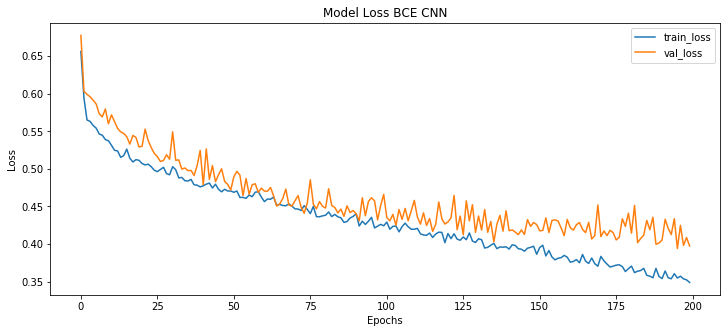

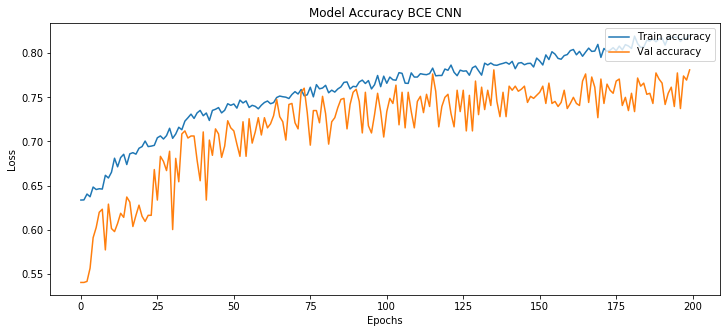

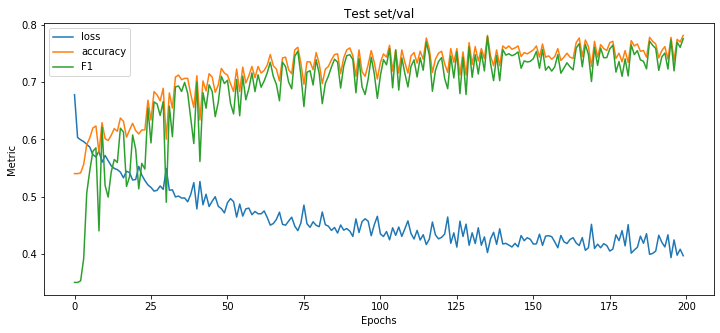

In [14]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

#model.add(GlobalAveragePooling2D())
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128*2)  #save model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      608       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
__________

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.839933    0.799519  0.819228     0.772676  0.752695   
Confirmed            0.658003    0.716841  0.686163     0.772676  0.752695   

                F1 micro  
False Positive  0.770594  
Confirmed       0.770594

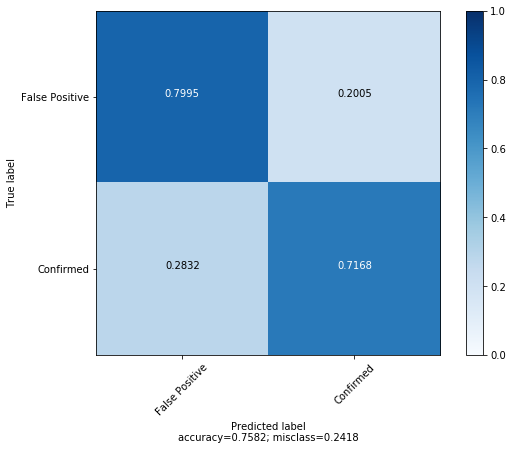

{'Precision raw': array([0.8399326 , 0.65800274]),
 'Recall raw': array([0.79951885, 0.71684054]),
 'F1 raw': array([0.81922761, 0.68616262]),
 'F1 weighted': 0.7726756775399258,
 'F1 macro': 0.7526951168479821,
 'F1 micro': 0.7705943691345152,
 'Confusion Matrix': array([[997, 250],
        [190, 481]])}

In [15]:
model = keras.models.load_model("best_mod.hdf5") #con 4 capas (32 y luego 64) con dropa en todo
model.summary()

predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #con 3 capas aumentando/double

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      608       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        9248      
__________

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 - val_f1: 0.350785 
7810/7810 [==============================] - 41s 5ms/step - loss: 0.6599 - acc: 0.6314 - val_loss: 0.6850 - val_acc: 0.5403
Epoch 2/200
7810/7810 [==============================] - 34s 4ms/step - loss: 0.6109 - acc: 0.6367 - val_loss: 0.6023 - val_acc: 0.6382
Epoch 3/200
7810/7810 [==============================] - 36s 5ms/step - loss: 0.5699 - acc: 0.6314 - val_loss: 0.6004 - val_acc: 0.5403
Epoch 4/200
7810/7810 [==============================] - 37s 5ms/step - loss: 0.5631 - acc: 0.6382 - val_loss: 0.5982 - val_acc: 0.5403
Epoch 5/200
7810/7810 [==============================] - 37s 5ms/step - loss: 0.5599 - acc: 0.6416 - val_loss: 0.5945 - val_acc: 0.5565
Epoch 6/200
7810/7810 [==============================] - 37s 5ms/step - loss: 0.5553 - acc: 0.6504 - val_loss: 0.5910 - val_acc: 0.5991
Epoch 7/200
7810/7810 [==============================] - 37s 5ms/step - loss: 0.5527 - acc: 0.6420 - val_loss: 0.5838 - val_acc: 0.5818
Epoch 8/200
7810/7810 [================

Epoch 36/200
7810/7810 [==============================] - 36s 5ms/step - loss: 0.4985 - acc: 0.7036 - val_loss: 0.5353 - val_acc: 0.6233
Epoch 37/200
7810/7810 [==============================] - 36s 5ms/step - loss: 0.4984 - acc: 0.7022 - val_loss: 0.5157 - val_acc: 0.6544
Epoch 38/200
7810/7810 [==============================] - 37s 5ms/step - loss: 0.4931 - acc: 0.7097 - val_loss: 0.5340 - val_acc: 0.6221
Epoch 39/200
7810/7810 [==============================] - 36s 5ms/step - loss: 0.4972 - acc: 0.7142 - val_loss: 0.5104 - val_acc: 0.6786
Epoch 40/200
7810/7810 [==============================] - 37s 5ms/step - loss: 0.4911 - acc: 0.7108 - val_loss: 0.5171 - val_acc: 0.6498
Epoch 41/200
7810/7810 [==============================] - 36s 5ms/step - loss: 0.4912 - acc: 0.7122 - val_loss: 0.5224 - val_acc: 0.6578
Epoch 42/200
7810/7810 [==============================] - 37s 5ms/step - loss: 0.4925 - acc: 0.7123 - val_loss: 0.5207 - val_acc: 0.6544
Epoch 43/200
7810/7810 [=================

7810/7810 [==============================] - 36s 5ms/step - loss: 0.4466 - acc: 0.7543 - val_loss: 0.4763 - val_acc: 0.6912
Epoch 105/200
7810/7810 [==============================] - 36s 5ms/step - loss: 0.4394 - acc: 0.7588 - val_loss: 0.4693 - val_acc: 0.7166
Epoch 106/200
7810/7810 [==============================] - 36s 5ms/step - loss: 0.4425 - acc: 0.7548 - val_loss: 0.4682 - val_acc: 0.7143
Epoch 107/200
7810/7810 [==============================] - 37s 5ms/step - loss: 0.4461 - acc: 0.7549 - val_loss: 0.4506 - val_acc: 0.7362
Epoch 108/200
7810/7810 [==============================] - 36s 5ms/step - loss: 0.4468 - acc: 0.7547 - val_loss: 0.5006 - val_acc: 0.6786
Epoch 109/200
7810/7810 [==============================] - 37s 5ms/step - loss: 0.4443 - acc: 0.7620 - val_loss: 0.4595 - val_acc: 0.7200
Epoch 110/200
7810/7810 [==============================] - 36s 5ms/step - loss: 0.4462 - acc: 0.7561 - val_loss: 0.4606 - val_acc: 0.7177
Epoch 111/200
7810/7810 [=======================

7810/7810 [==============================] - 35s 5ms/step - loss: 0.4170 - acc: 0.7750 - val_loss: 0.4495 - val_acc: 0.7373
Epoch 173/200
7810/7810 [==============================] - 36s 5ms/step - loss: 0.4177 - acc: 0.7741 - val_loss: 0.4302 - val_acc: 0.7627
Epoch 174/200
7810/7810 [==============================] - 36s 5ms/step - loss: 0.4165 - acc: 0.7746 - val_loss: 0.4465 - val_acc: 0.7350
Epoch 175/200
7810/7810 [==============================] - 36s 5ms/step - loss: 0.4196 - acc: 0.7727 - val_loss: 0.4610 - val_acc: 0.7212
Epoch 176/200
7810/7810 [==============================] - 37s 5ms/step - loss: 0.4098 - acc: 0.7770 - val_loss: 0.4338 - val_acc: 0.7604
Epoch 177/200
7810/7810 [==============================] - 35s 5ms/step - loss: 0.4106 - acc: 0.7786 - val_loss: 0.4299 - val_acc: 0.7488
Epoch 178/200
7810/7810 [==============================] - 36s 5ms/step - loss: 0.4151 - acc: 0.7753 - val_loss: 0.4423 - val_acc: 0.7373
Epoch 179/200
7810/7810 [=======================

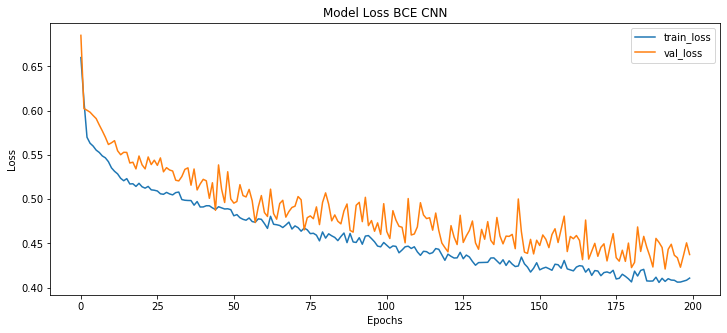

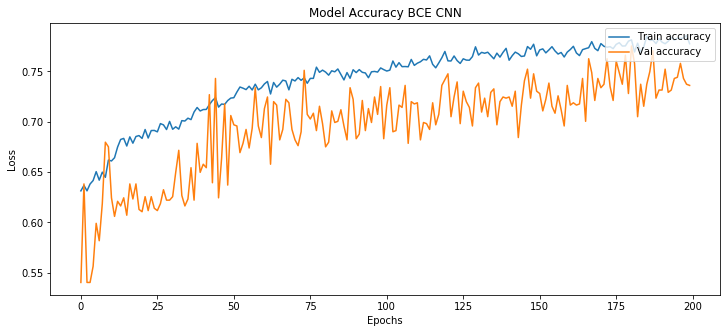

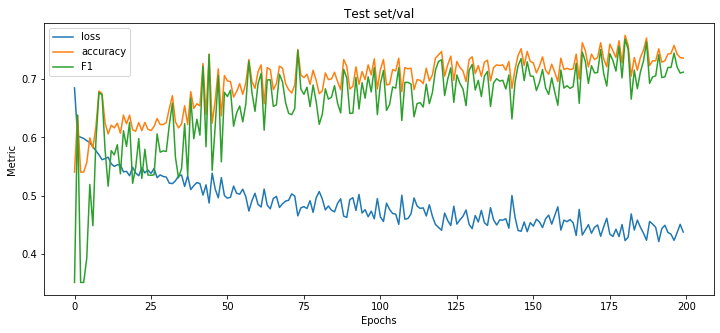

In [19]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

#model.add(GlobalAveragePooling2D())
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128*2)  #save model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      608       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        9248      
__________

Precision raw  Recall raw   F1 raw  F1 weighted  F1 macro  \
False Positive       0.819820    0.875702  0.84684     0.790487    0.7663   
Confirmed            0.735495    0.642325  0.68576     0.790487    0.7663   

                F1 micro  
False Positive  0.794056  
Confirmed       0.794056

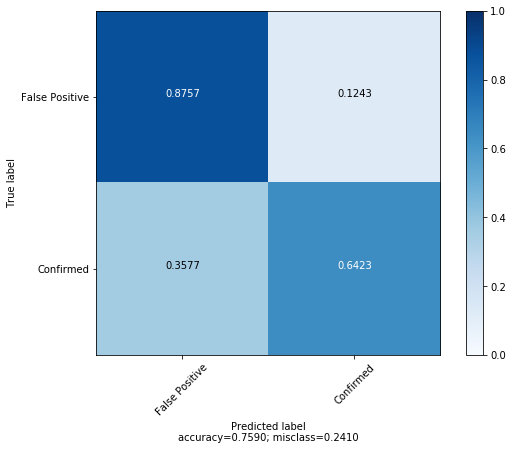

{'Precision raw': array([0.81981982, 0.73549488]),
 'Recall raw': array([0.87570168, 0.64232489]),
 'F1 raw': array([0.84683986, 0.68575975]),
 'F1 weighted': 0.7904870151788951,
 'F1 macro': 0.7662998029183143,
 'F1 micro': 0.7940563086548488,
 'Confusion Matrix': array([[1092,  155],
        [ 240,  431]])}

In [20]:
model = keras.models.load_model("best_mod.hdf5") #con 4 capas (32) con dropa en todo
model.summary()

predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #con 3 capas aumentando/double

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 126, 126, 64)      1216      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 128)       73856     
__________

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 - val_f1: 0.350785 
7810/7810 [==============================] - 74s 9ms/step - loss: 0.6592 - acc: 0.6364 - val_loss: 0.6687 - val_acc: 0.5403
Epoch 2/200
7810/7810 [==============================] - 78s 10ms/step - loss: 0.5817 - acc: 0.6371 - val_loss: 0.6083 - val_acc: 0.5403
Epoch 3/200
7810/7810 [==============================] - 72s 9ms/step - loss: 0.5632 - acc: 0.6430 - val_loss: 0.6057 - val_acc: 0.5403
Epoch 4/200
7810/7810 [==============================] - 76s 10ms/step - loss: 0.5606 - acc: 0.6433 - val_loss: 0.6163 - val_acc: 0.5403
Epoch 5/200
7810/7810 [==============================] - 73s 9ms/step - loss: 0.5576 - acc: 0.6424 - val_loss: 0.5925 - val_acc: 0.5403
Epoch 6/200
7810/7810 [==============================] - 71s 9ms/step - loss: 0.5501 - acc: 0.6490 - val_loss: 0.5901 - val_acc: 0.5588
Epoch 7/200
7810/7810 [==============================] - 71s 9ms/step - loss: 0.5441 - acc: 0.6504 - val_loss: 0.5925 - val_acc: 0.5795
Epoch 8/200
7810/7810 [==============

Epoch 36/200
7810/7810 [==============================] - 75s 10ms/step - loss: 0.4881 - acc: 0.7193 - val_loss: 0.4943 - val_acc: 0.7085
Epoch 37/200
7810/7810 [==============================] - 72s 9ms/step - loss: 0.4881 - acc: 0.7156 - val_loss: 0.5175 - val_acc: 0.6452
Epoch 38/200
7810/7810 [==============================] - 72s 9ms/step - loss: 0.4819 - acc: 0.7273 - val_loss: 0.5312 - val_acc: 0.6371
Epoch 39/200
7810/7810 [==============================] - 74s 10ms/step - loss: 0.4936 - acc: 0.7152 - val_loss: 0.5071 - val_acc: 0.6763
Epoch 40/200
7810/7810 [==============================] - 71s 9ms/step - loss: 0.4788 - acc: 0.7279 - val_loss: 0.5003 - val_acc: 0.6901
Epoch 41/200
7810/7810 [==============================] - 75s 10ms/step - loss: 0.4806 - acc: 0.7319 - val_loss: 0.5167 - val_acc: 0.6705
Epoch 42/200
7810/7810 [==============================] - 73s 9ms/step - loss: 0.4795 - acc: 0.7291 - val_loss: 0.5156 - val_acc: 0.6555
Epoch 43/200
7810/7810 [==============

7810/7810 [==============================] - 73s 9ms/step - loss: 0.4117 - acc: 0.7816 - val_loss: 0.4870 - val_acc: 0.7062
Epoch 105/200
7810/7810 [==============================] - 73s 9ms/step - loss: 0.4089 - acc: 0.7808 - val_loss: 0.4346 - val_acc: 0.7684
Epoch 106/200
7810/7810 [==============================] - 75s 10ms/step - loss: 0.4111 - acc: 0.7814 - val_loss: 0.4301 - val_acc: 0.7638
Epoch 107/200
7810/7810 [==============================] - 71s 9ms/step - loss: 0.4083 - acc: 0.7770 - val_loss: 0.4336 - val_acc: 0.7673
Epoch 108/200
7810/7810 [==============================] - 75s 10ms/step - loss: 0.4065 - acc: 0.7834 - val_loss: 0.4341 - val_acc: 0.7615
Epoch 109/200
7810/7810 [==============================] - 76s 10ms/step - loss: 0.4051 - acc: 0.7831 - val_loss: 0.4368 - val_acc: 0.7477
Epoch 110/200
7810/7810 [==============================] - 71s 9ms/step - loss: 0.4041 - acc: 0.7832 - val_loss: 0.4212 - val_acc: 0.7719
Epoch 111/200
7810/7810 [====================

7810/7810 [==============================] - 70s 9ms/step - loss: 0.3437 - acc: 0.8278 - val_loss: 0.4047 - val_acc: 0.7730
Epoch 173/200
7810/7810 [==============================] - 75s 10ms/step - loss: 0.3420 - acc: 0.8234 - val_loss: 0.4583 - val_acc: 0.7488
Epoch 174/200
7810/7810 [==============================] - 73s 9ms/step - loss: 0.3447 - acc: 0.8207 - val_loss: 0.4136 - val_acc: 0.7765
Epoch 175/200
7810/7810 [==============================] - 74s 9ms/step - loss: 0.3311 - acc: 0.8319 - val_loss: 0.4354 - val_acc: 0.7696
Epoch 176/200
7810/7810 [==============================] - 74s 9ms/step - loss: 0.3375 - acc: 0.8301 - val_loss: 0.4330 - val_acc: 0.7661
Epoch 177/200
7810/7810 [==============================] - 74s 10ms/step - loss: 0.3418 - acc: 0.8255 - val_loss: 0.4491 - val_acc: 0.7442
Epoch 178/200
7810/7810 [==============================] - 77s 10ms/step - loss: 0.3422 - acc: 0.8303 - val_loss: 0.4276 - val_acc: 0.7661
Epoch 179/200
7810/7810 [====================

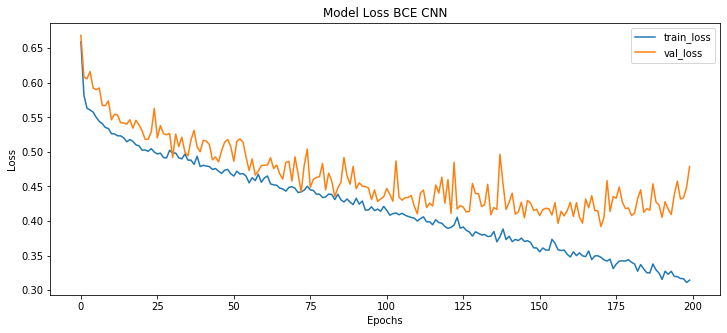

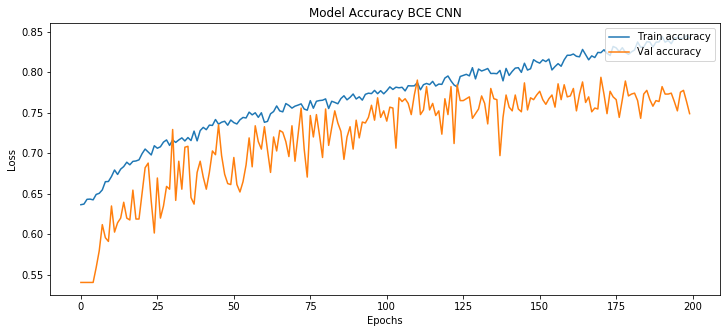

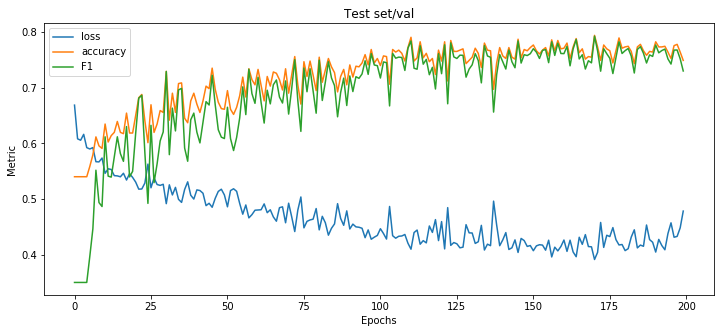

In [21]:
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128 ,(3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128 ,(3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

#model.add(GlobalAveragePooling2D())
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128*2)  #save model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 126, 126, 64)      1216      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 128)       73856     
__________

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.857401    0.761828  0.806794     0.766905  0.749785   
Confirmed            0.633333    0.764531  0.692775     0.766905  0.749785   

                F1 micro  
False Positive  0.762774  
Confirmed       0.762774

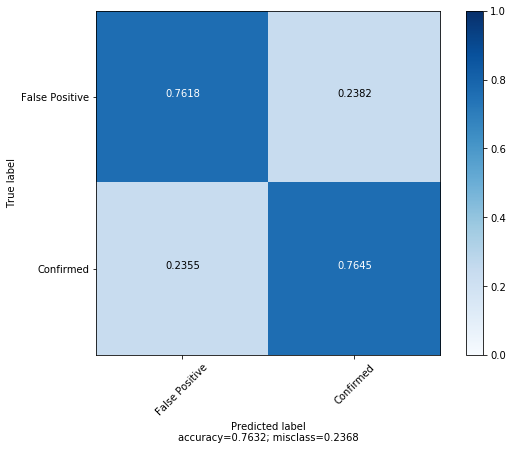

{'Precision raw': array([0.85740072, 0.63333333]),
 'Recall raw': array([0.76182839, 0.76453055]),
 'F1 raw': array([0.80679406, 0.69277515]),
 'F1 weighted': 0.7669052730853879,
 'F1 macro': 0.749784603563037,
 'F1 micro': 0.7627737226277372,
 'Confusion Matrix': array([[950, 297],
        [158, 513]])}

In [22]:
model = keras.models.load_model("best_mod.hdf5") #con 4 capas (64 y 128) con dropa en todo
model.summary()

predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #con 3 capas aumentando/double






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 64)      1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
______________________

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 - val_f1: 0.350785 
7810/7810 [==============================] - 38s 5ms/step - loss: 0.6627 - acc: 0.6352 - val_loss: 0.7021 - val_acc: 0.5403
Epoch 2/200
7810/7810 [==============================] - 33s 4ms/step - loss: 0.6543 - acc: 0.6388 - val_loss: 0.7164 - val_acc: 0.5403
Epoch 3/200
7810/7810 [==============================] - 34s 4ms/step - loss: 0.6115 - acc: 0.6388 - val_loss: 0.6145 - val_acc: 0.5403
Epoch 4/200
7810/7810 [==============================] - 34s 4ms/step - loss: 0.5678 - acc: 0.6388 - val_loss: 0.6156 - val_acc: 0.5403
Epoch 5/200
7810/7810 [==============================] - 33s 4ms/step - loss: 0.5632 - acc: 0.6388 - val_loss: 0.6019 - val_acc: 0.5403
Epoch 6/200
7810/7810 [==============================] - 31s 4ms/step - loss: 0.5612 - acc: 0.6388 - val_loss: 0.6007 - val_acc: 0.5403
Epoch 7/200
7810/7810 [==============================] - 35s 5ms/step - loss: 0.5600 - acc: 0.6388 - val_loss: 0.6043 - val_acc: 0.5403
Epoch 8/200
7810/7810 [================

Epoch 36/200
7810/7810 [==============================] - 35s 4ms/step - loss: 0.5183 - acc: 0.6653 - val_loss: 0.5518 - val_acc: 0.6647
Epoch 37/200
7810/7810 [==============================] - 31s 4ms/step - loss: 0.5127 - acc: 0.6807 - val_loss: 0.5462 - val_acc: 0.6406
Epoch 38/200
7810/7810 [==============================] - 33s 4ms/step - loss: 0.5105 - acc: 0.6867 - val_loss: 0.5324 - val_acc: 0.7016
Epoch 39/200
7810/7810 [==============================] - 34s 4ms/step - loss: 0.5118 - acc: 0.6857 - val_loss: 0.5415 - val_acc: 0.6555
Epoch 40/200
7810/7810 [==============================] - 34s 4ms/step - loss: 0.5086 - acc: 0.6803 - val_loss: 0.5671 - val_acc: 0.5945
Epoch 41/200
7810/7810 [==============================] - 32s 4ms/step - loss: 0.5076 - acc: 0.6873 - val_loss: 0.5319 - val_acc: 0.7039
Epoch 42/200
7810/7810 [==============================] - 33s 4ms/step - loss: 0.5088 - acc: 0.6781 - val_loss: 0.5390 - val_acc: 0.6889
Epoch 43/200
7810/7810 [=================

7810/7810 [==============================] - 36s 5ms/step - loss: 0.4434 - acc: 0.7589 - val_loss: 0.5264 - val_acc: 0.6751
Epoch 71/200
7810/7810 [==============================] - 30s 4ms/step - loss: 0.4334 - acc: 0.7630 - val_loss: 0.4797 - val_acc: 0.7373
Epoch 72/200
7810/7810 [==============================] - 33s 4ms/step - loss: 0.4292 - acc: 0.7667 - val_loss: 0.4513 - val_acc: 0.7581
Epoch 73/200
7810/7810 [==============================] - 34s 4ms/step - loss: 0.4307 - acc: 0.7653 - val_loss: 0.4554 - val_acc: 0.7350
Epoch 74/200
7810/7810 [==============================] - 34s 4ms/step - loss: 0.4294 - acc: 0.7633 - val_loss: 0.4547 - val_acc: 0.7362
Epoch 75/200
7810/7810 [==============================] - 32s 4ms/step - loss: 0.4429 - acc: 0.7576 - val_loss: 0.4999 - val_acc: 0.6959
Epoch 76/200
7810/7810 [==============================] - 33s 4ms/step - loss: 0.4305 - acc: 0.7681 - val_loss: 0.4558 - val_acc: 0.7327
Epoch 77/200
7810/7810 [==============================

7810/7810 [==============================] - 33s 4ms/step - loss: 0.3861 - acc: 0.7953 - val_loss: 0.4775 - val_acc: 0.7131
Epoch 105/200
7810/7810 [==============================] - 34s 4ms/step - loss: 0.3819 - acc: 0.8019 - val_loss: 0.4328 - val_acc: 0.7661
Epoch 106/200
7810/7810 [==============================] - 33s 4ms/step - loss: 0.3751 - acc: 0.8054 - val_loss: 0.4299 - val_acc: 0.7627
Epoch 107/200
7810/7810 [==============================] - 35s 4ms/step - loss: 0.3724 - acc: 0.8067 - val_loss: 0.4579 - val_acc: 0.7396
Epoch 108/200
7810/7810 [==============================] - 32s 4ms/step - loss: 0.3718 - acc: 0.8081 - val_loss: 0.4399 - val_acc: 0.7546
Epoch 109/200
7810/7810 [==============================] - 34s 4ms/step - loss: 0.3827 - acc: 0.8012 - val_loss: 0.4536 - val_acc: 0.7385
Epoch 110/200
7810/7810 [==============================] - 32s 4ms/step - loss: 0.3869 - acc: 0.7976 - val_loss: 0.4714 - val_acc: 0.7281
Epoch 111/200
7810/7810 [=======================

7810/7810 [==============================] - 33s 4ms/step - loss: 0.3249 - acc: 0.8435 - val_loss: 0.4765 - val_acc: 0.7535
Epoch 139/200
7810/7810 [==============================] - 33s 4ms/step - loss: 0.3329 - acc: 0.8367 - val_loss: 0.4952 - val_acc: 0.7362
Epoch 140/200
7810/7810 [==============================] - 35s 4ms/step - loss: 0.3191 - acc: 0.8437 - val_loss: 0.4401 - val_acc: 0.7604
Epoch 141/200
7810/7810 [==============================] - 32s 4ms/step - loss: 0.3281 - acc: 0.8438 - val_loss: 0.4423 - val_acc: 0.7569
Epoch 142/200
7810/7810 [==============================] - 33s 4ms/step - loss: 0.3224 - acc: 0.8410 - val_loss: 0.4599 - val_acc: 0.7454
Epoch 143/200
7810/7810 [==============================] - 33s 4ms/step - loss: 0.3193 - acc: 0.8443 - val_loss: 0.4309 - val_acc: 0.7627
Epoch 144/200
7810/7810 [==============================] - 34s 4ms/step - loss: 0.3142 - acc: 0.8479 - val_loss: 0.4837 - val_acc: 0.7477
Epoch 145/200
7810/7810 [=======================

7810/7810 [==============================] - 34s 4ms/step - loss: 0.2460 - acc: 0.8895 - val_loss: 0.4866 - val_acc: 0.7546
Epoch 173/200
7810/7810 [==============================] - 33s 4ms/step - loss: 0.2582 - acc: 0.8866 - val_loss: 0.5040 - val_acc: 0.7477
Epoch 174/200
7810/7810 [==============================] - 34s 4ms/step - loss: 0.2572 - acc: 0.8862 - val_loss: 0.4690 - val_acc: 0.7638
Epoch 175/200
7810/7810 [==============================] - 35s 4ms/step - loss: 0.2447 - acc: 0.8896 - val_loss: 0.4588 - val_acc: 0.7742
Epoch 176/200
7810/7810 [==============================] - 32s 4ms/step - loss: 0.2433 - acc: 0.8890 - val_loss: 0.4790 - val_acc: 0.7627
Epoch 177/200
7810/7810 [==============================] - 36s 5ms/step - loss: 0.2479 - acc: 0.8901 - val_loss: 0.5181 - val_acc: 0.7465
Epoch 178/200
7810/7810 [==============================] - 31s 4ms/step - loss: 0.2381 - acc: 0.8923 - val_loss: 0.4744 - val_acc: 0.7753
Epoch 179/200
7810/7810 [=======================

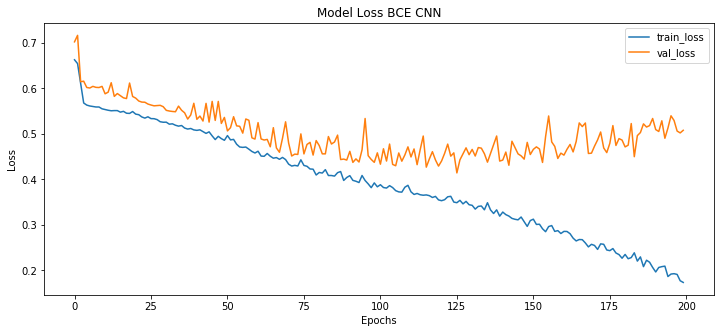

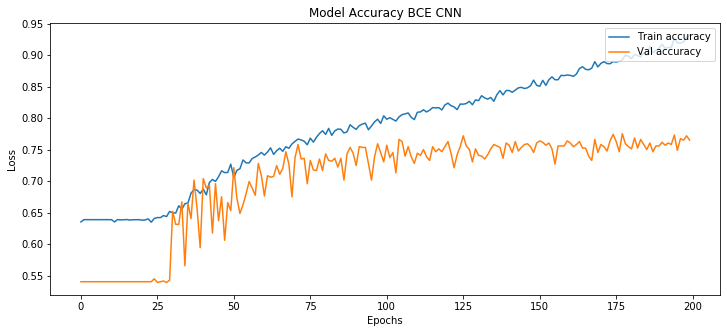

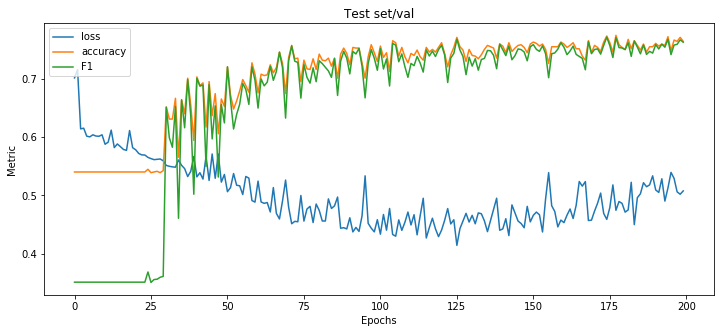

In [14]:
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
#model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
#model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(GlobalAveragePooling2D())
#model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128*2)  #save model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 64)      1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 128)       0         
__________

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.846491    0.773857  0.808546     0.765188  0.746578   
Confirmed            0.637532    0.739195  0.684610     0.765188  0.746578   

                F1 micro  
False Positive  0.761731  
Confirmed       0.761731

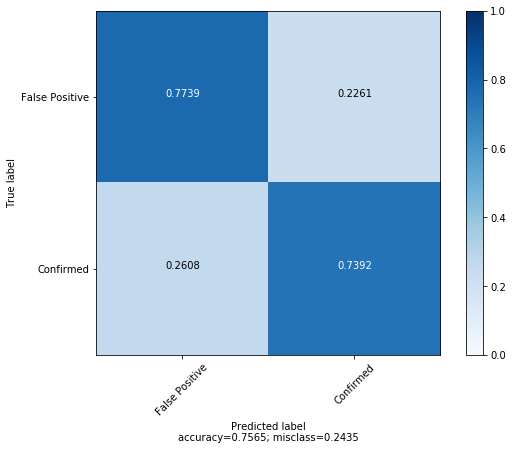

{'Precision raw': array([0.84649123, 0.63753213]),
 'Recall raw': array([0.77385726, 0.73919523]),
 'F1 raw': array([0.80854629, 0.68461008]),
 'F1 weighted': 0.7651880018680405,
 'F1 macro': 0.7465781841658419,
 'F1 micro': 0.7617309697601669,
 'Confusion Matrix': array([[965, 282],
        [175, 496]])}

In [15]:
model = keras.models.load_model("best_mod.hdf5") #con 4 capas (64 y 128) con dropa en todo + Global
model.summary()

predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #con 3 capas aumentando/double

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 126, 126, 32)      608       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 128)       73856     
__________

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 - val_f1: 0.350785 
7810/7810 [==============================] - 58s 7ms/step - loss: 0.6644 - acc: 0.6350 - val_loss: 0.6929 - val_acc: 0.5403
Epoch 2/200
7810/7810 [==============================] - 51s 7ms/step - loss: 0.6508 - acc: 0.6388 - val_loss: 0.6701 - val_acc: 0.5403
Epoch 3/200
7810/7810 [==============================] - 52s 7ms/step - loss: 0.5832 - acc: 0.6388 - val_loss: 0.6127 - val_acc: 0.5403
Epoch 4/200
7810/7810 [==============================] - 55s 7ms/step - loss: 0.5679 - acc: 0.6388 - val_loss: 0.6043 - val_acc: 0.5403
Epoch 5/200
7810/7810 [==============================] - 52s 7ms/step - loss: 0.5641 - acc: 0.6388 - val_loss: 0.6021 - val_acc: 0.5403
Epoch 6/200
7810/7810 [==============================] - 53s 7ms/step - loss: 0.5636 - acc: 0.6388 - val_loss: 0.6044 - val_acc: 0.5403
Epoch 7/200
7810/7810 [==============================] - 51s 7ms/step - loss: 0.5607 - acc: 0.6388 - val_loss: 0.6002 - val_acc: 0.5403
Epoch 8/200
7810/7810 [================

Epoch 36/200
7810/7810 [==============================] - 55s 7ms/step - loss: 0.5296 - acc: 0.6380 - val_loss: 0.5563 - val_acc: 0.5403
Epoch 37/200
7810/7810 [==============================] - 53s 7ms/step - loss: 0.5242 - acc: 0.6453 - val_loss: 0.5522 - val_acc: 0.6498
Epoch 38/200
7810/7810 [==============================] - 51s 7ms/step - loss: 0.5247 - acc: 0.6420 - val_loss: 0.5555 - val_acc: 0.5415
Epoch 39/200
7810/7810 [==============================] - 54s 7ms/step - loss: 0.5246 - acc: 0.6442 - val_loss: 0.5529 - val_acc: 0.5864
Epoch 40/200
7810/7810 [==============================] - 52s 7ms/step - loss: 0.5261 - acc: 0.6426 - val_loss: 0.5618 - val_acc: 0.6198
Epoch 41/200
7810/7810 [==============================] - 52s 7ms/step - loss: 0.5290 - acc: 0.6480 - val_loss: 0.5542 - val_acc: 0.5541
Epoch 42/200
7810/7810 [==============================] - 52s 7ms/step - loss: 0.5233 - acc: 0.6501 - val_loss: 0.5487 - val_acc: 0.5956
Epoch 43/200
7810/7810 [=================

7810/7810 [==============================] - 53s 7ms/step - loss: 0.4758 - acc: 0.7319 - val_loss: 0.5206 - val_acc: 0.6590
Epoch 71/200
7810/7810 [==============================] - 54s 7ms/step - loss: 0.4750 - acc: 0.7259 - val_loss: 0.5268 - val_acc: 0.6555
Epoch 72/200
7810/7810 [==============================] - 52s 7ms/step - loss: 0.4755 - acc: 0.7269 - val_loss: 0.4939 - val_acc: 0.6889
Epoch 73/200
7810/7810 [==============================] - 52s 7ms/step - loss: 0.4682 - acc: 0.7327 - val_loss: 0.5030 - val_acc: 0.6855
Epoch 74/200
7810/7810 [==============================] - 55s 7ms/step - loss: 0.4687 - acc: 0.7327 - val_loss: 0.5220 - val_acc: 0.6601
Epoch 75/200
7810/7810 [==============================] - 55s 7ms/step - loss: 0.4654 - acc: 0.7401 - val_loss: 0.4979 - val_acc: 0.6878
Epoch 76/200
7810/7810 [==============================] - 53s 7ms/step - loss: 0.4655 - acc: 0.7357 - val_loss: 0.5006 - val_acc: 0.6843
Epoch 77/200
7810/7810 [==============================

7810/7810 [==============================] - 51s 6ms/step - loss: 0.4290 - acc: 0.7668 - val_loss: 0.4596 - val_acc: 0.7350
Epoch 105/200
7810/7810 [==============================] - 55s 7ms/step - loss: 0.4355 - acc: 0.7579 - val_loss: 0.4661 - val_acc: 0.7247
Epoch 106/200
7810/7810 [==============================] - 53s 7ms/step - loss: 0.4271 - acc: 0.7653 - val_loss: 0.4608 - val_acc: 0.7247
Epoch 107/200
7810/7810 [==============================] - 50s 6ms/step - loss: 0.4313 - acc: 0.7668 - val_loss: 0.4669 - val_acc: 0.7212
Epoch 108/200
7810/7810 [==============================] - 51s 7ms/step - loss: 0.4322 - acc: 0.7640 - val_loss: 0.4663 - val_acc: 0.7316
Epoch 109/200
7810/7810 [==============================] - 55s 7ms/step - loss: 0.4361 - acc: 0.7636 - val_loss: 0.4940 - val_acc: 0.6855
Epoch 110/200
7810/7810 [==============================] - 51s 6ms/step - loss: 0.4369 - acc: 0.7589 - val_loss: 0.4689 - val_acc: 0.7131
Epoch 111/200
7810/7810 [=======================

7810/7810 [==============================] - 52s 7ms/step - loss: 0.4031 - acc: 0.7821 - val_loss: 0.4395 - val_acc: 0.7569
Epoch 139/200
7810/7810 [==============================] - 53s 7ms/step - loss: 0.4067 - acc: 0.7780 - val_loss: 0.4419 - val_acc: 0.7465
Epoch 140/200
7810/7810 [==============================] - 51s 7ms/step - loss: 0.4078 - acc: 0.7790 - val_loss: 0.4424 - val_acc: 0.7431
Epoch 141/200
7810/7810 [==============================] - 55s 7ms/step - loss: 0.4065 - acc: 0.7786 - val_loss: 0.4437 - val_acc: 0.7408
Epoch 142/200
7810/7810 [==============================] - 52s 7ms/step - loss: 0.3973 - acc: 0.7876 - val_loss: 0.4491 - val_acc: 0.7258
Epoch 143/200
7810/7810 [==============================] - 52s 7ms/step - loss: 0.4027 - acc: 0.7837 - val_loss: 0.4378 - val_acc: 0.7408
Epoch 144/200
7810/7810 [==============================] - 55s 7ms/step - loss: 0.4009 - acc: 0.7830 - val_loss: 0.4471 - val_acc: 0.7304
Epoch 145/200
7810/7810 [=======================

7810/7810 [==============================] - 52s 7ms/step - loss: 0.3856 - acc: 0.7990 - val_loss: 0.4372 - val_acc: 0.7408
Epoch 173/200
7810/7810 [==============================] - 54s 7ms/step - loss: 0.3801 - acc: 0.8060 - val_loss: 0.4323 - val_acc: 0.7535
Epoch 174/200
7810/7810 [==============================] - 53s 7ms/step - loss: 0.3780 - acc: 0.7995 - val_loss: 0.4260 - val_acc: 0.7627
Epoch 175/200
7810/7810 [==============================] - 52s 7ms/step - loss: 0.3754 - acc: 0.8044 - val_loss: 0.4543 - val_acc: 0.7212
Epoch 176/200
7810/7810 [==============================] - 53s 7ms/step - loss: 0.3841 - acc: 0.8038 - val_loss: 0.4427 - val_acc: 0.7396
Epoch 177/200
7810/7810 [==============================] - 54s 7ms/step - loss: 0.3842 - acc: 0.7977 - val_loss: 0.4275 - val_acc: 0.7523
Epoch 178/200
7810/7810 [==============================] - 54s 7ms/step - loss: 0.3781 - acc: 0.8010 - val_loss: 0.4242 - val_acc: 0.7638
Epoch 179/200
7810/7810 [=======================

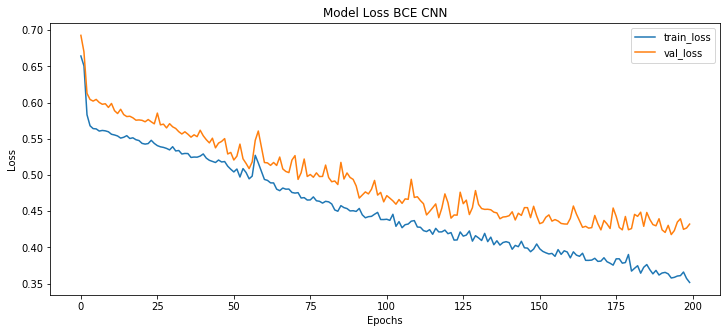

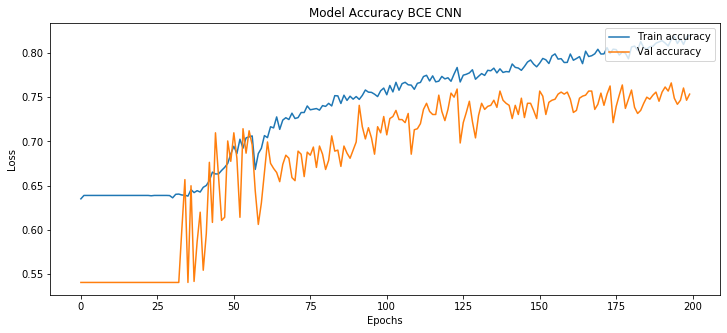

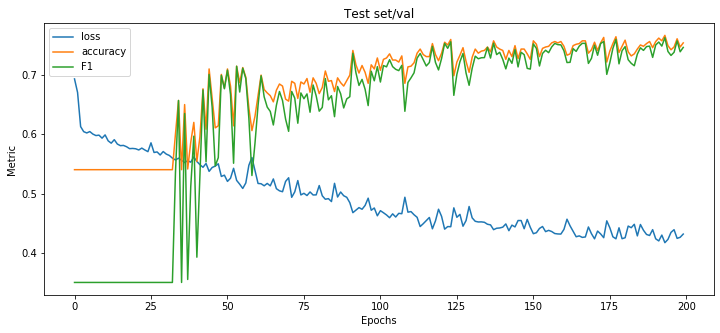

In [16]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128 ,(3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256 ,(3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(GlobalAveragePooling2D())
#model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128*2)  #save model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 126, 126, 32)      608       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 128)       73856     
__________

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.832226    0.803528  0.817625     0.768518  0.747441   
Confirmed            0.656863    0.698957  0.677256     0.768518  0.747441   

                F1 micro  
False Positive  0.766945  
Confirmed       0.766945

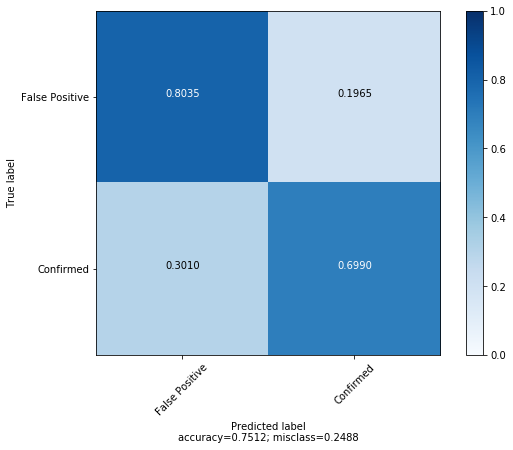

{'Precision raw': array([0.83222591, 0.65686275]),
 'Recall raw': array([0.80352847, 0.69895678]),
 'F1 raw': array([0.81762546, 0.67725632]),
 'F1 weighted': 0.7685182150876414,
 'F1 macro': 0.7474408883429293,
 'F1 micro': 0.7669447340980188,
 'Confusion Matrix': array([[1002,  245],
        [ 202,  469]])}

In [17]:
model = keras.models.load_model("best_mod.hdf5") #con 4 capas (32 en aumento) con dropa en todo + Global
model.summary()

predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #con 3 capas aumentando/double

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 126, 126, 32)      608       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 128)       73856     
__________

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 - val_f1: 0.350785 
7810/7810 [==============================] - 59s 8ms/step - loss: 0.6587 - acc: 0.6382 - val_loss: 0.7017 - val_acc: 0.5403
Epoch 2/200
7810/7810 [==============================] - 51s 7ms/step - loss: 0.6551 - acc: 0.6388 - val_loss: 0.6854 - val_acc: 0.5403
Epoch 3/200
7810/7810 [==============================] - 49s 6ms/step - loss: 0.5936 - acc: 0.6388 - val_loss: 0.6077 - val_acc: 0.5403
Epoch 4/200
7810/7810 [==============================] - 56s 7ms/step - loss: 0.5648 - acc: 0.6388 - val_loss: 0.6035 - val_acc: 0.5403
Epoch 5/200
7810/7810 [==============================] - 55s 7ms/step - loss: 0.5628 - acc: 0.6388 - val_loss: 0.5993 - val_acc: 0.5403
Epoch 6/200
7810/7810 [==============================] - 51s 7ms/step - loss: 0.5612 - acc: 0.6388 - val_loss: 0.6052 - val_acc: 0.5403
Epoch 7/200
7810/7810 [==============================] - 52s 7ms/step - loss: 0.5603 - acc: 0.6388 - val_loss: 0.6036 - val_acc: 0.5403
Epoch 8/200
7810/7810 [================

Epoch 36/200
7810/7810 [==============================] - 53s 7ms/step - loss: 0.5179 - acc: 0.6730 - val_loss: 0.5390 - val_acc: 0.6935
Epoch 37/200
7810/7810 [==============================] - 53s 7ms/step - loss: 0.5202 - acc: 0.6656 - val_loss: 0.5471 - val_acc: 0.6924
Epoch 38/200
7810/7810 [==============================] - 53s 7ms/step - loss: 0.5218 - acc: 0.6676 - val_loss: 0.5604 - val_acc: 0.5691
Epoch 39/200
7810/7810 [==============================] - 54s 7ms/step - loss: 0.5156 - acc: 0.6805 - val_loss: 0.5478 - val_acc: 0.6002
Epoch 40/200
7810/7810 [==============================] - 52s 7ms/step - loss: 0.5098 - acc: 0.6904 - val_loss: 0.5197 - val_acc: 0.7074
Epoch 41/200
7810/7810 [==============================] - 55s 7ms/step - loss: 0.5132 - acc: 0.6859 - val_loss: 0.5284 - val_acc: 0.6947
Epoch 42/200
7810/7810 [==============================] - 54s 7ms/step - loss: 0.5046 - acc: 0.7004 - val_loss: 0.5274 - val_acc: 0.6728
Epoch 43/200
7810/7810 [=================

7810/7810 [==============================] - 54s 7ms/step - loss: 0.4539 - acc: 0.7484 - val_loss: 0.4834 - val_acc: 0.7085
Epoch 71/200
7810/7810 [==============================] - 53s 7ms/step - loss: 0.4451 - acc: 0.7566 - val_loss: 0.4523 - val_acc: 0.7304
Epoch 72/200
7810/7810 [==============================] - 53s 7ms/step - loss: 0.4437 - acc: 0.7589 - val_loss: 0.4990 - val_acc: 0.6843
Epoch 73/200
7810/7810 [==============================] - 52s 7ms/step - loss: 0.4432 - acc: 0.7561 - val_loss: 0.5054 - val_acc: 0.6901
Epoch 74/200
7810/7810 [==============================] - 54s 7ms/step - loss: 0.4447 - acc: 0.7515 - val_loss: 0.4512 - val_acc: 0.7385
Epoch 75/200
7810/7810 [==============================] - 54s 7ms/step - loss: 0.4383 - acc: 0.7621 - val_loss: 0.4713 - val_acc: 0.7200
Epoch 76/200
7810/7810 [==============================] - 53s 7ms/step - loss: 0.4319 - acc: 0.7658 - val_loss: 0.4618 - val_acc: 0.7224
Epoch 77/200
7810/7810 [==============================

7810/7810 [==============================] - 52s 7ms/step - loss: 0.4121 - acc: 0.7803 - val_loss: 0.4291 - val_acc: 0.7523
Epoch 105/200
7810/7810 [==============================] - 55s 7ms/step - loss: 0.4063 - acc: 0.7817 - val_loss: 0.4408 - val_acc: 0.7350
Epoch 106/200
7810/7810 [==============================] - 51s 7ms/step - loss: 0.4056 - acc: 0.7834 - val_loss: 0.4302 - val_acc: 0.7535
Epoch 107/200
7810/7810 [==============================] - 55s 7ms/step - loss: 0.4137 - acc: 0.7754 - val_loss: 0.4398 - val_acc: 0.7408
Epoch 108/200
7810/7810 [==============================] - 52s 7ms/step - loss: 0.4101 - acc: 0.7796 - val_loss: 0.4356 - val_acc: 0.7385
Epoch 109/200
7810/7810 [==============================] - 54s 7ms/step - loss: 0.4036 - acc: 0.7828 - val_loss: 0.4252 - val_acc: 0.7523
Epoch 110/200
7810/7810 [==============================] - 54s 7ms/step - loss: 0.3979 - acc: 0.7887 - val_loss: 0.4267 - val_acc: 0.7488
Epoch 111/200
7810/7810 [=======================

7810/7810 [==============================] - 54s 7ms/step - loss: 0.3695 - acc: 0.8101 - val_loss: 0.4167 - val_acc: 0.7615
Epoch 139/200
7810/7810 [==============================] - 54s 7ms/step - loss: 0.3770 - acc: 0.8037 - val_loss: 0.4349 - val_acc: 0.7546
Epoch 140/200
7810/7810 [==============================] - 55s 7ms/step - loss: 0.3717 - acc: 0.8056 - val_loss: 0.4116 - val_acc: 0.7581
Epoch 141/200
7810/7810 [==============================] - 54s 7ms/step - loss: 0.3624 - acc: 0.8155 - val_loss: 0.4108 - val_acc: 0.7684
Epoch 142/200
7810/7810 [==============================] - 54s 7ms/step - loss: 0.3733 - acc: 0.8078 - val_loss: 0.4178 - val_acc: 0.7419
Epoch 143/200
7810/7810 [==============================] - 54s 7ms/step - loss: 0.3758 - acc: 0.8037 - val_loss: 0.4057 - val_acc: 0.7604
Epoch 144/200
7810/7810 [==============================] - 54s 7ms/step - loss: 0.3756 - acc: 0.8088 - val_loss: 0.4110 - val_acc: 0.7673
Epoch 145/200
7810/7810 [=======================

7810/7810 [==============================] - 55s 7ms/step - loss: 0.3343 - acc: 0.8314 - val_loss: 0.4033 - val_acc: 0.7707
Epoch 173/200
7810/7810 [==============================] - 54s 7ms/step - loss: 0.3478 - acc: 0.8252 - val_loss: 0.4196 - val_acc: 0.7661
Epoch 174/200
7810/7810 [==============================] - 54s 7ms/step - loss: 0.3481 - acc: 0.8219 - val_loss: 0.4752 - val_acc: 0.7327
Epoch 175/200
7810/7810 [==============================] - 54s 7ms/step - loss: 0.3569 - acc: 0.8170 - val_loss: 0.4045 - val_acc: 0.7627
Epoch 176/200
7810/7810 [==============================] - 54s 7ms/step - loss: 0.3368 - acc: 0.8307 - val_loss: 0.4184 - val_acc: 0.7581
Epoch 177/200
7810/7810 [==============================] - 54s 7ms/step - loss: 0.3367 - acc: 0.8329 - val_loss: 0.4132 - val_acc: 0.7604
Epoch 178/200
7810/7810 [==============================] - 55s 7ms/step - loss: 0.3356 - acc: 0.8323 - val_loss: 0.4301 - val_acc: 0.7638
Epoch 179/200
7810/7810 [=======================

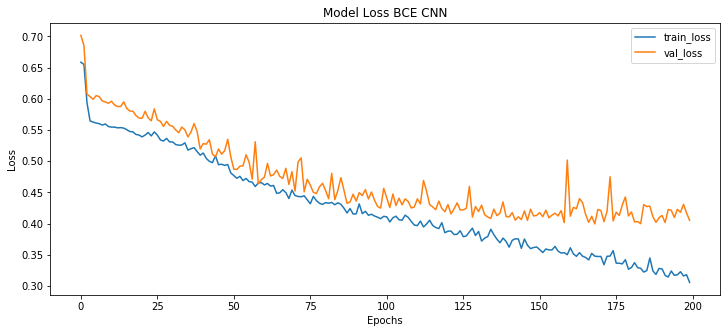

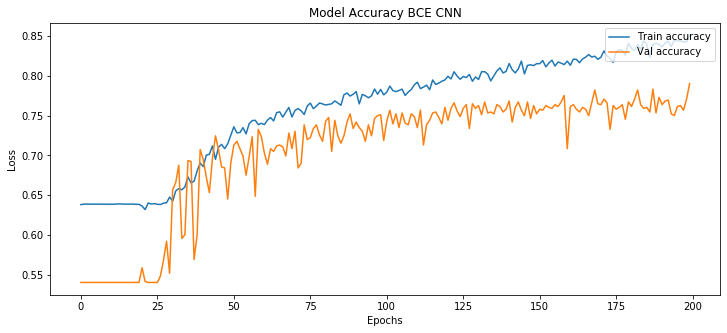

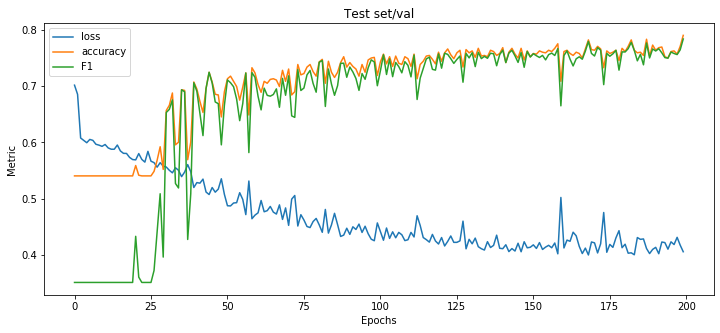

In [18]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128 ,(3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(256 ,(3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())
#model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128*2)  #save model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 126, 126, 32)      608       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 128)       73856     
__________

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.841969    0.781877  0.810811     0.765761  0.746426   
Confirmed            0.642105    0.727273  0.682041     0.765761  0.746426   

                F1 micro  
False Positive  0.762774  
Confirmed       0.762774

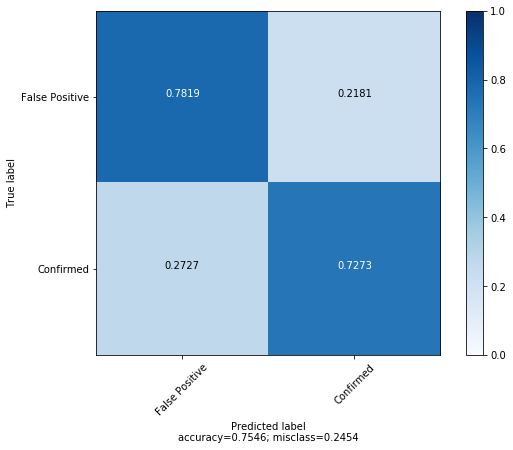

{'Precision raw': array([0.84196891, 0.64210526]),
 'Recall raw': array([0.7818765 , 0.72727273]),
 'F1 raw': array([0.81081081, 0.68204053]),
 'F1 weighted': 0.7657613542477887,
 'F1 macro': 0.7464256709539728,
 'F1 micro': 0.7627737226277372,
 'Confusion Matrix': array([[975, 272],
        [183, 488]])}

In [19]:
model = keras.models.load_model("best_mod.hdf5") #con 4 capas (32 en aumento) con dropa en todo + Global
model.summary()

predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #con 3 capas aumentando/double

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 28, 28, 32)        608       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_59 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_60 (Dropout)         (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 1152)            

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.815946    0.878107  0.845886     0.787863  0.762959   
Confirmed            0.736111    0.631893  0.680032     0.787863  0.762959   

                F1 micro  
False Positive  0.791971  
Confirmed       0.791971

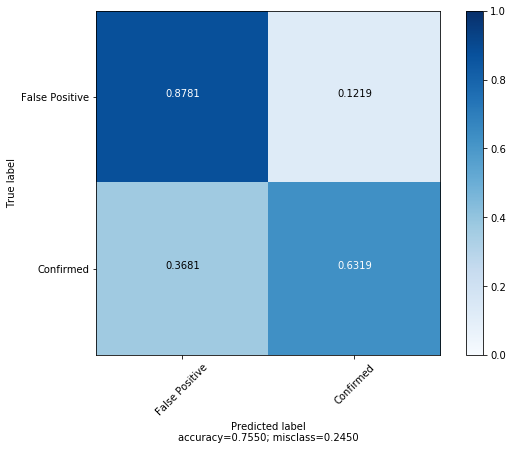

{'Precision raw': array([0.81594635, 0.73611111]),
 'Recall raw': array([0.87810746, 0.6318927 ]),
 'F1 raw': array([0.84588644, 0.68003208]),
 'F1 weighted': 0.7878633564292408,
 'F1 macro': 0.7629592598133551,
 'F1 micro': 0.791970802919708,
 'Confusion Matrix': array([[1095,  152],
        [ 247,  424]])}

In [76]:
model = keras.models.load_model("best_mod.hdf5")
model.summary()

predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')

Train on 7810 samples, validate on 868 samples
Epoch 1/200
7810/7810 [==============================] - 5s 608us/step - loss: 0.6531 - acc: 0.6318 - val_loss: 0.6634 - val_acc: 0.5403


/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 - val_f1: 0.350785 
Epoch 2/200
7810/7810 [==============================] - 2s 266us/step - loss: 0.5977 - acc: 0.6361 - val_loss: 0.5967 - val_acc: 0.6244
 - val_f1: 0.624183 
Epoch 3/200
7810/7810 [==============================] - 2s 262us/step - loss: 0.5636 - acc: 0.6207 - val_loss: 0.5850 - val_acc: 0.5541
 - val_f1: 0.457092 
Epoch 4/200
7810/7810 [==============================] - 2s 254us/step - loss: 0.5532 - acc: 0.6230 - val_loss: 0.5790 - val_acc: 0.5541
 - val_f1: 0.440646 
Epoch 5/200
7810/7810 [==============================] - 2s 255us/step - loss: 0.5451 - acc: 0.6283 - val_loss: 0.5743 - val_acc: 0.5449
 - val_f1: 0.361764 
Epoch 6/200
7810/7810 [==============================] - 2s 282us/step - loss: 0.5437 - acc: 0.6370 - val_loss: 0.5686 - val_acc: 0.6244
 - val_f1: 0.597627 
Epoch 7/200
7810/7810 [==============================] - 3s 322us/step - loss: 0.5394 - acc: 0.6398 - val_loss: 0.5668 - val_acc: 0.5979
 - val_f1: 0.542133 
Epoch 8/200
7810/7810 [========

7810/7810 [==============================] - 2s 265us/step - loss: 0.4617 - acc: 0.7330 - val_loss: 0.4825 - val_acc: 0.7085
 - val_f1: 0.693365 
Epoch 105/200
7810/7810 [==============================] - 2s 273us/step - loss: 0.4597 - acc: 0.7327 - val_loss: 0.4808 - val_acc: 0.7154
 - val_f1: 0.699984 
Epoch 106/200
7810/7810 [==============================] - 2s 266us/step - loss: 0.4584 - acc: 0.7356 - val_loss: 0.4769 - val_acc: 0.7281
 - val_f1: 0.719274 
Epoch 107/200
7810/7810 [==============================] - 2s 260us/step - loss: 0.4584 - acc: 0.7373 - val_loss: 0.4833 - val_acc: 0.7028
 - val_f1: 0.678602 
Epoch 108/200
7810/7810 [==============================] - 2s 268us/step - loss: 0.4608 - acc: 0.7370 - val_loss: 0.4933 - val_acc: 0.6935
 - val_f1: 0.661256 
Epoch 109/200
7810/7810 [==============================] - 2s 287us/step - loss: 0.4601 - acc: 0.7341 - val_loss: 0.4770 - val_acc: 0.7247
 - val_f1: 0.708723 
Epoch 110/200
7810/7810 [=============================

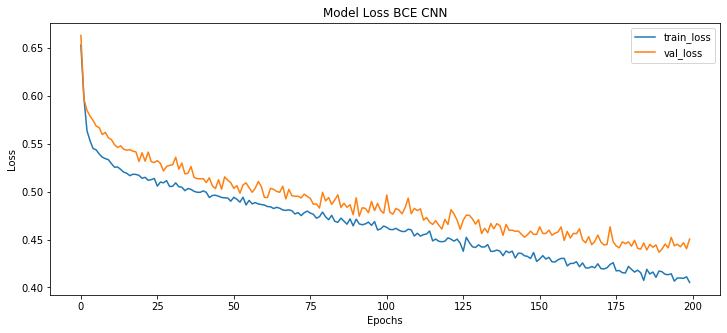

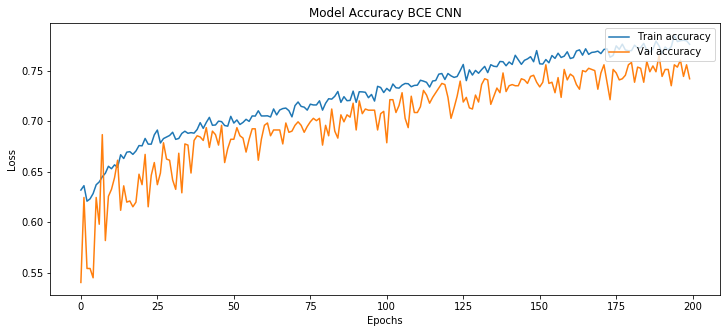

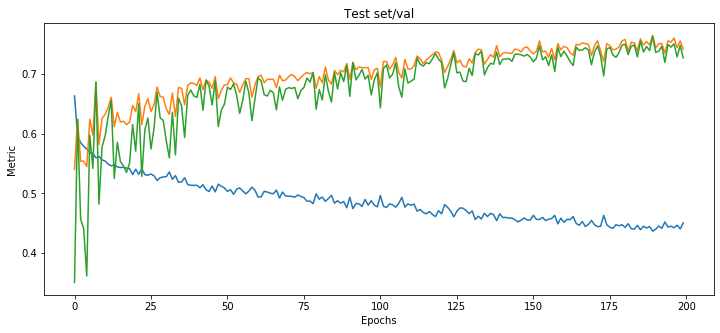

Best f1 macro trough iters 0.763256 on 189 


Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.785665    0.914194  0.845070      0.77077   0.73888   
Confirmed            0.770878    0.536513  0.632689      0.77077   0.73888   

                F1 micro  
False Positive  0.782065  
Confirmed       0.782065

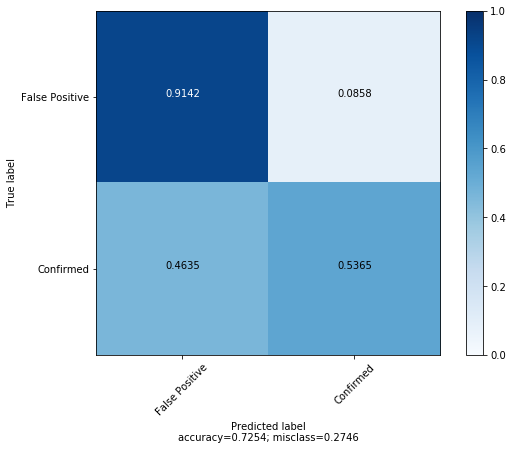

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 28, 28, 32)        608       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_62 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 1152)            

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.845643    0.817161  0.831158     0.785577  0.766013   
Confirmed            0.680224    0.722802  0.700867     0.785577  0.766013   

                F1 micro  
False Positive   0.78415  
Confirmed        0.78415

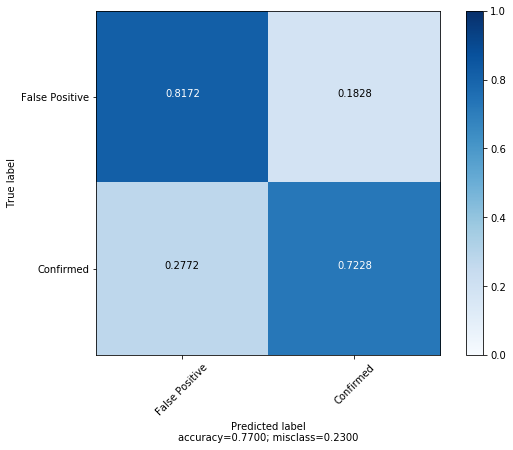

{'Precision raw': array([0.84564315, 0.6802244 ]),
 'Recall raw': array([0.81716119, 0.72280179]),
 'F1 raw': array([0.83115824, 0.70086705]),
 'F1 weighted': 0.7855767022466871,
 'F1 macro': 0.7660126450980207,
 'F1 micro': 0.7841501564129302,
 'Confusion Matrix': array([[1019,  228],
        [ 186,  485]])}

In [81]:
#con reduce lr #0.2 y lr 0.001 (pat 10)
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128*2, save_f='best_mod2.hdf5') 
model = keras.models.load_model("best_mod2.hdf5")
model.summary()

predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

In [23]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 28, 28, 32)        608       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1152)             

## focal loss
> sin lr decay

In [14]:
keras.losses.binary_focal_loss_fixed = keras.losses.mse

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.830709    0.846030  0.838300     0.786919  0.764866   
Confirmed            0.703704    0.679583  0.691433     0.786919  0.764866   

                F1 micro  
False Positive    0.7878  
Confirmed         0.7878

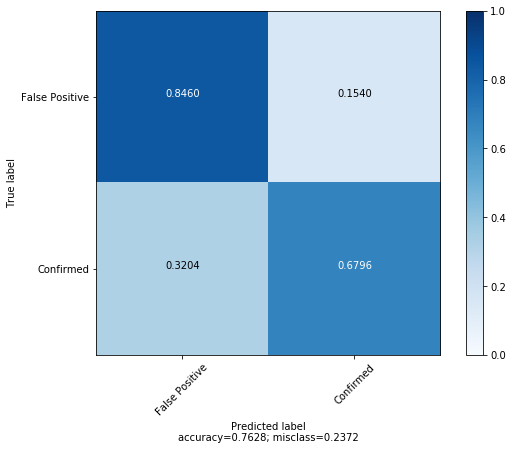

{'Precision raw': array([0.83070866, 0.7037037 ]),
 'Recall raw': array([0.84603047, 0.67958271]),
 'F1 raw': array([0.83829956, 0.6914329 ]),
 'F1 weighted': 0.7869192040764057,
 'F1 macro': 0.7648662333433638,
 'F1 micro': 0.7877997914494265,
 'Confusion Matrix': array([[1055,  192],
        [ 215,  456]])}

In [94]:
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128*2, focal=True, alpha=0.5)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

Train on 7810 samples, validate on 868 samples
Epoch 1/200
7810/7810 [==============================] - 6s 761us/step - loss: 20.4267 - acc: 0.6256 - val_loss: 18.7155 - val_acc: 0.6233
 - val_f1: 0.622791 
Epoch 2/200
7810/7810 [==============================] - 3s 343us/step - loss: 18.4884 - acc: 0.6312 - val_loss: 17.5552 - val_acc: 0.6774
 - val_f1: 0.666365 
Epoch 3/200
7810/7810 [==============================] - 2s 271us/step - loss: 17.8366 - acc: 0.6261 - val_loss: 17.2520 - val_acc: 0.6832
 - val_f1: 0.672180 
Epoch 4/200
7810/7810 [==============================] - 2s 278us/step - loss: 17.5078 - acc: 0.6320 - val_loss: 17.1491 - val_acc: 0.6843
 - val_f1: 0.675141 
Epoch 5/200
7810/7810 [==============================] - 2s 275us/step - loss: 17.3085 - acc: 0.6350 - val_loss: 17.0580 - val_acc: 0.6809
 - val_f1: 0.669211 
Epoch 6/200
7810/7810 [==============================] - 2s 271us/step - loss: 17.1576 - acc: 0.6352 - val_loss: 17.0128 - val_acc: 0.6866
 - val_f1: 0.6

 - val_f1: 0.688933 
Epoch 52/200
7810/7810 [==============================] - 2s 255us/step - loss: 15.3865 - acc: 0.6915 - val_loss: 15.1838 - val_acc: 0.7074
 - val_f1: 0.703111 
Epoch 53/200
7810/7810 [==============================] - 2s 258us/step - loss: 15.5357 - acc: 0.6988 - val_loss: 14.9918 - val_acc: 0.7189
 - val_f1: 0.717544 
Epoch 54/200
7810/7810 [==============================] - 2s 251us/step - loss: 15.3249 - acc: 0.6953 - val_loss: 14.8225 - val_acc: 0.6970
 - val_f1: 0.696511 
Epoch 55/200
7810/7810 [==============================] - 2s 257us/step - loss: 15.3946 - acc: 0.6932 - val_loss: 15.0843 - val_acc: 0.6959
 - val_f1: 0.692086 
Epoch 56/200
7810/7810 [==============================] - 2s 263us/step - loss: 15.3588 - acc: 0.7006 - val_loss: 15.0241 - val_acc: 0.6959
 - val_f1: 0.690126 
Epoch 57/200
7810/7810 [==============================] - 2s 285us/step - loss: 15.2928 - acc: 0.7019 - val_loss: 15.1272 - val_acc: 0.7005
 - val_f1: 0.694013 
Epoch 58/200


 - val_f1: 0.705013 
Epoch 103/200
7810/7810 [==============================] - 2s 248us/step - loss: 14.4645 - acc: 0.7234 - val_loss: 14.1351 - val_acc: 0.7166
 - val_f1: 0.715489 
Epoch 104/200
7810/7810 [==============================] - 2s 256us/step - loss: 14.5386 - acc: 0.7198 - val_loss: 14.1831 - val_acc: 0.7131
 - val_f1: 0.712996 
Epoch 105/200
7810/7810 [==============================] - 2s 266us/step - loss: 14.3654 - acc: 0.7255 - val_loss: 14.2819 - val_acc: 0.7074
 - val_f1: 0.701671 
Epoch 106/200
7810/7810 [==============================] - 2s 257us/step - loss: 14.4024 - acc: 0.7273 - val_loss: 14.2676 - val_acc: 0.7120
 - val_f1: 0.707105 
Epoch 107/200
7810/7810 [==============================] - 2s 264us/step - loss: 14.2773 - acc: 0.7190 - val_loss: 14.2695 - val_acc: 0.7293
 - val_f1: 0.727541 
Epoch 108/200
7810/7810 [==============================] - 2s 251us/step - loss: 14.4136 - acc: 0.7309 - val_loss: 14.4624 - val_acc: 0.7108
 - val_f1: 0.701305 
Epoch 1

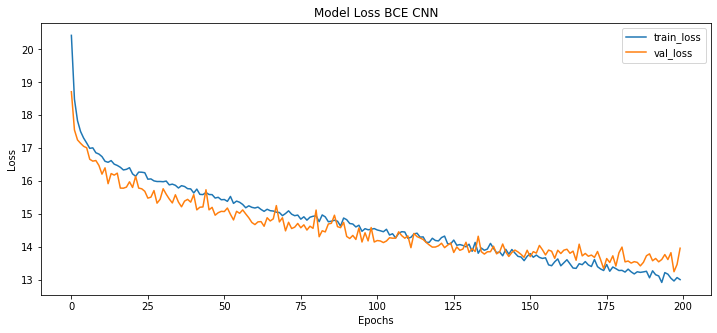

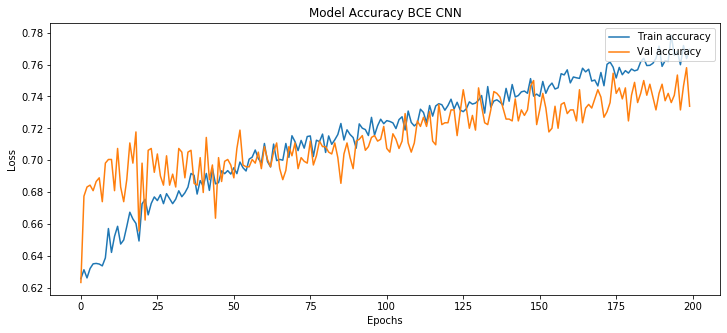

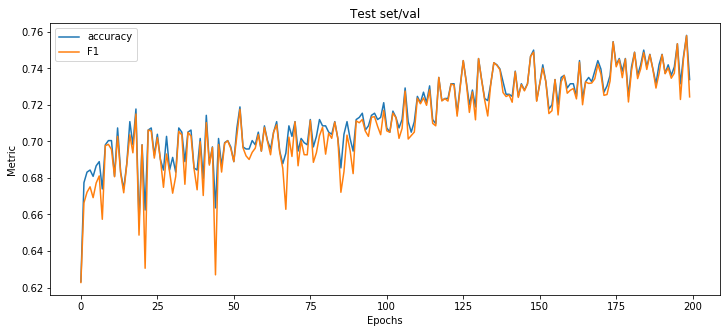

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.841202    0.785886  0.812604     0.767117  0.747594   
Confirmed            0.645418    0.724292  0.682584     0.767117  0.747594   

                F1 micro  
False Positive  0.764338  
Confirmed       0.764338

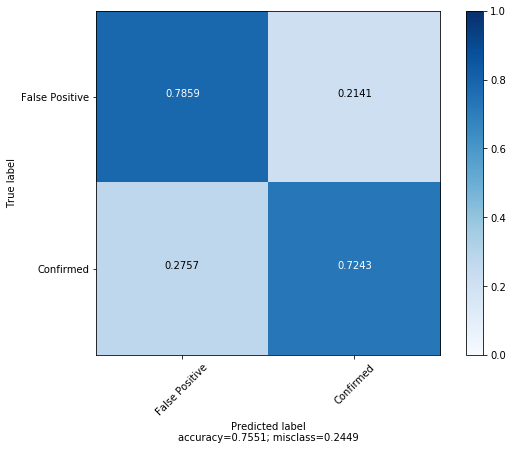

{'Precision raw': array([0.84120172, 0.64541833]),
 'Recall raw': array([0.78588613, 0.7242921 ]),
 'F1 raw': array([0.81260365, 0.68258427]),
 'F1 weighted': 0.7671172025699824,
 'F1 macro': 0.7475939590437326,
 'F1 micro': 0.7643378519290928,
 'Confusion Matrix': array([[980, 267],
        [185, 486]])}

In [96]:
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128*2, focal=True, alpha=0.55)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

Train on 7810 samples, validate on 868 samples
Epoch 1/200
7810/7810 [==============================] - 6s 739us/step - loss: 19.8933 - acc: 0.6029 - val_loss: 17.6028 - val_acc: 0.6590
 - val_f1: 0.655445 
Epoch 2/200
7810/7810 [==============================] - 2s 290us/step - loss: 18.0875 - acc: 0.6198 - val_loss: 17.2140 - val_acc: 0.6613
 - val_f1: 0.644989 
Epoch 3/200
7810/7810 [==============================] - 2s 289us/step - loss: 17.5266 - acc: 0.6163 - val_loss: 17.1791 - val_acc: 0.6774
 - val_f1: 0.664552 
Epoch 4/200
7810/7810 [==============================] - 2s 280us/step - loss: 17.1876 - acc: 0.6166 - val_loss: 16.7580 - val_acc: 0.6751
 - val_f1: 0.661837 
Epoch 5/200
7810/7810 [==============================] - 2s 279us/step - loss: 17.0529 - acc: 0.6165 - val_loss: 16.8063 - val_acc: 0.6786
 - val_f1: 0.664952 
Epoch 6/200
7810/7810 [==============================] - 2s 298us/step - loss: 16.9041 - acc: 0.6188 - val_loss: 16.5356 - val_acc: 0.6809
 - val_f1: 0.6

 - val_f1: 0.704089 
Epoch 52/200
7810/7810 [==============================] - 2s 298us/step - loss: 15.2959 - acc: 0.6580 - val_loss: 14.6477 - val_acc: 0.7005
 - val_f1: 0.689089 
Epoch 53/200
7810/7810 [==============================] - 2s 271us/step - loss: 15.1233 - acc: 0.6691 - val_loss: 14.8034 - val_acc: 0.7028
 - val_f1: 0.693865 
Epoch 54/200
7810/7810 [==============================] - 2s 272us/step - loss: 15.2453 - acc: 0.6603 - val_loss: 14.7767 - val_acc: 0.7062
 - val_f1: 0.695483 
Epoch 55/200
7810/7810 [==============================] - 2s 259us/step - loss: 15.1365 - acc: 0.6672 - val_loss: 14.8553 - val_acc: 0.6947
 - val_f1: 0.680822 
Epoch 56/200
7810/7810 [==============================] - 2s 287us/step - loss: 15.2103 - acc: 0.6603 - val_loss: 14.8829 - val_acc: 0.6993
 - val_f1: 0.690430 
Epoch 57/200
7810/7810 [==============================] - 2s 285us/step - loss: 15.3204 - acc: 0.6633 - val_loss: 14.8241 - val_acc: 0.7051
 - val_f1: 0.696482 
Epoch 58/200


 - val_f1: 0.715879 
Epoch 103/200
7810/7810 [==============================] - 2s 285us/step - loss: 14.3665 - acc: 0.6960 - val_loss: 13.7875 - val_acc: 0.7258
 - val_f1: 0.719711 
Epoch 104/200
7810/7810 [==============================] - 2s 285us/step - loss: 14.2224 - acc: 0.6942 - val_loss: 13.8508 - val_acc: 0.7270
 - val_f1: 0.719341 
Epoch 105/200
7810/7810 [==============================] - 2s 259us/step - loss: 14.2158 - acc: 0.6994 - val_loss: 14.0305 - val_acc: 0.7316
 - val_f1: 0.731464 
Epoch 106/200
7810/7810 [==============================] - 2s 265us/step - loss: 14.3109 - acc: 0.7004 - val_loss: 13.8766 - val_acc: 0.7258
 - val_f1: 0.718483 
Epoch 107/200
7810/7810 [==============================] - 2s 278us/step - loss: 14.3133 - acc: 0.6996 - val_loss: 13.8740 - val_acc: 0.7247
 - val_f1: 0.719559 
Epoch 108/200
7810/7810 [==============================] - 2s 285us/step - loss: 14.2255 - acc: 0.7020 - val_loss: 13.9489 - val_acc: 0.7442
 - val_f1: 0.740515 
Epoch 1

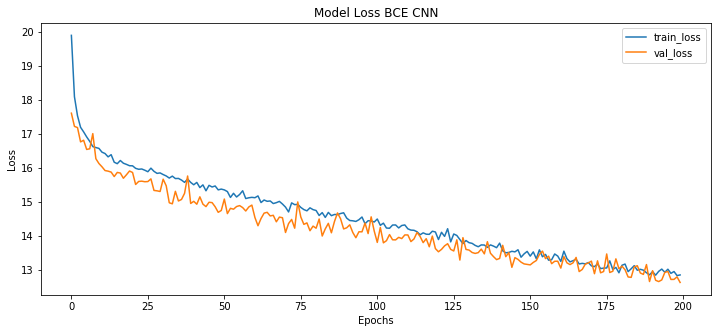

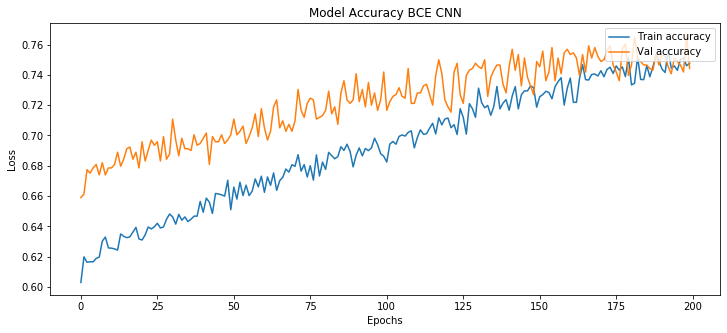

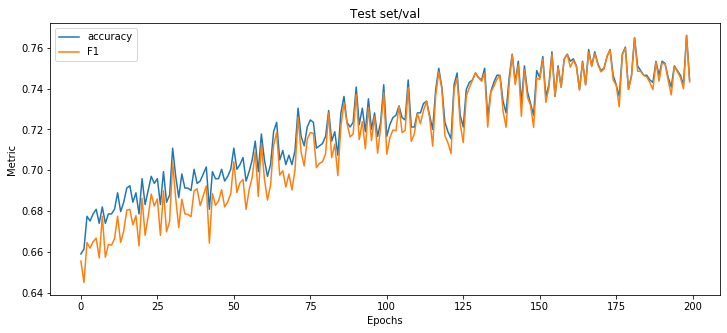

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.896885    0.669607  0.766758     0.741167  0.730183   
Confirmed            0.582573    0.856930  0.693607     0.741167  0.730183   

                F1 micro  
False Positive  0.735141  
Confirmed       0.735141

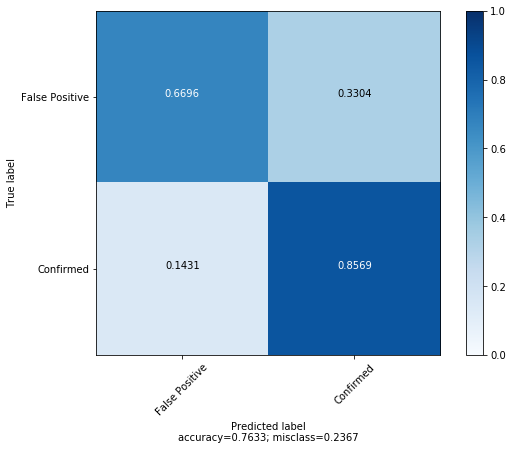

{'Precision raw': array([0.89688507, 0.58257345]),
 'Recall raw': array([0.66960706, 0.85692996]),
 'F1 raw': array([0.76675849, 0.69360676]),
 'F1 weighted': 0.741166827292451,
 'F1 macro': 0.73018262457894,
 'F1 micro': 0.7351407716371221,
 'Confusion Matrix': array([[835, 412],
        [ 96, 575]])}

In [98]:
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128*2, focal=True, alpha=0.6)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

Train on 7810 samples, validate on 868 samples
Epoch 1/200
7810/7810 [==============================] - 6s 775us/step - loss: 19.3365 - acc: 0.5738 - val_loss: 16.9663 - val_acc: 0.6682
 - val_f1: 0.658268 
Epoch 2/200
7810/7810 [==============================] - 2s 293us/step - loss: 17.5761 - acc: 0.6193 - val_loss: 16.5030 - val_acc: 0.6728
 - val_f1: 0.660077 
Epoch 3/200
7810/7810 [==============================] - 2s 284us/step - loss: 16.9542 - acc: 0.6136 - val_loss: 16.8204 - val_acc: 0.6843
 - val_f1: 0.673514 
Epoch 4/200
7810/7810 [==============================] - 2s 294us/step - loss: 16.7063 - acc: 0.6136 - val_loss: 16.1066 - val_acc: 0.6751
 - val_f1: 0.659124 
Epoch 5/200
7810/7810 [==============================] - 2s 280us/step - loss: 16.4826 - acc: 0.6170 - val_loss: 16.1015 - val_acc: 0.6647
 - val_f1: 0.644942 
Epoch 6/200
7810/7810 [==============================] - 2s 310us/step - loss: 16.3120 - acc: 0.6170 - val_loss: 16.1301 - val_acc: 0.6763
 - val_f1: 0.6

 - val_f1: 0.699987 
Epoch 52/200
7810/7810 [==============================] - 3s 359us/step - loss: 14.5228 - acc: 0.6607 - val_loss: 13.8662 - val_acc: 0.7016
 - val_f1: 0.690143 
Epoch 53/200
7810/7810 [==============================] - 3s 349us/step - loss: 14.5324 - acc: 0.6525 - val_loss: 13.9884 - val_acc: 0.6959
 - val_f1: 0.682185 
Epoch 54/200
7810/7810 [==============================] - 2s 298us/step - loss: 14.5818 - acc: 0.6543 - val_loss: 14.0931 - val_acc: 0.6970
 - val_f1: 0.684471 
Epoch 55/200
7810/7810 [==============================] - 3s 368us/step - loss: 14.4520 - acc: 0.6563 - val_loss: 13.9565 - val_acc: 0.7051
 - val_f1: 0.693873 
Epoch 56/200
7810/7810 [==============================] - 3s 361us/step - loss: 14.4336 - acc: 0.6627 - val_loss: 14.0806 - val_acc: 0.7005
 - val_f1: 0.688218 
Epoch 57/200
7810/7810 [==============================] - 3s 390us/step - loss: 14.4166 - acc: 0.6597 - val_loss: 13.7822 - val_acc: 0.7039
 - val_f1: 0.692817 
Epoch 58/200


 - val_f1: 0.712616 
Epoch 103/200
7810/7810 [==============================] - 2s 295us/step - loss: 13.5199 - acc: 0.6900 - val_loss: 13.4686 - val_acc: 0.7154
 - val_f1: 0.704770 
Epoch 104/200
7810/7810 [==============================] - 2s 319us/step - loss: 13.4371 - acc: 0.6871 - val_loss: 13.0180 - val_acc: 0.7212
 - val_f1: 0.713308 
Epoch 105/200
7810/7810 [==============================] - 2s 307us/step - loss: 13.5738 - acc: 0.6926 - val_loss: 13.0123 - val_acc: 0.7131
 - val_f1: 0.702913 
Epoch 106/200
7810/7810 [==============================] - 3s 354us/step - loss: 13.3507 - acc: 0.6959 - val_loss: 13.3369 - val_acc: 0.7408
 - val_f1: 0.737081 
Epoch 107/200
7810/7810 [==============================] - 2s 265us/step - loss: 13.3822 - acc: 0.6986 - val_loss: 12.7574 - val_acc: 0.7166
 - val_f1: 0.706878 
Epoch 108/200
7810/7810 [==============================] - 2s 285us/step - loss: 13.4201 - acc: 0.6959 - val_loss: 12.9922 - val_acc: 0.7339
 - val_f1: 0.728235 
Epoch 1

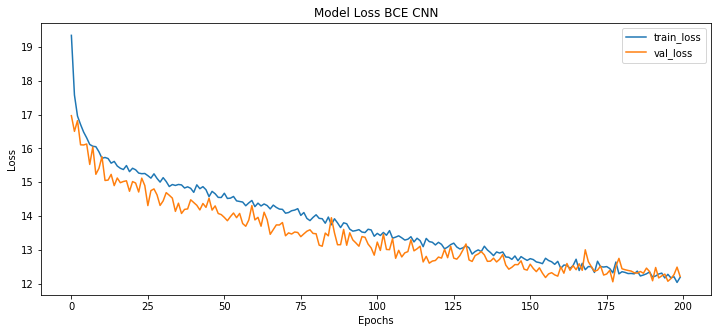

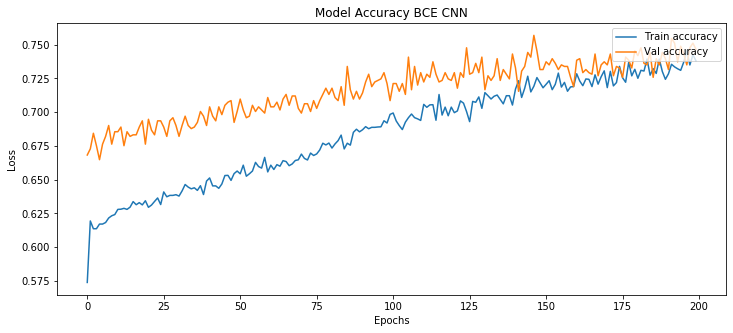

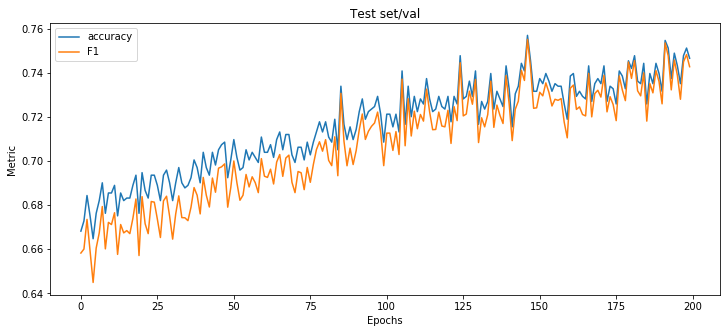

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.936486    0.555734  0.697534     0.689636  0.686247   
Confirmed            0.529711    0.929955  0.674959     0.689636  0.686247   

                F1 micro  
False Positive  0.686653  
Confirmed       0.686653

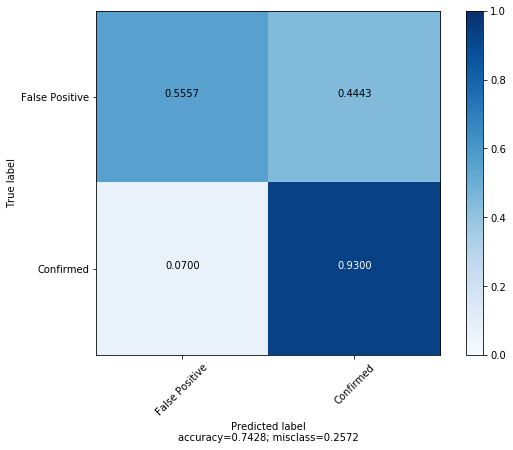

{'Precision raw': array([0.93648649, 0.52971138]),
 'Recall raw': array([0.55573376, 0.92995529]),
 'F1 raw': array([0.69753397, 0.67495944]),
 'F1 weighted': 0.6896364151124004,
 'F1 macro': 0.6862467041720344,
 'F1 micro': 0.6866527632950991,
 'Confusion Matrix': array([[693, 554],
        [ 47, 624]])}

In [100]:
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128*2, focal=True, alpha=0.65)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

Train on 7810 samples, validate on 868 samples
Epoch 1/200
7810/7810 [==============================] - 7s 836us/step - loss: 20.1006 - acc: 0.6346 - val_loss: 18.0762 - val_acc: 0.6394
 - val_f1: 0.639377 
Epoch 2/200
7810/7810 [==============================] - 4s 527us/step - loss: 18.3651 - acc: 0.6298 - val_loss: 17.5923 - val_acc: 0.6521
 - val_f1: 0.652074 
Epoch 3/200
7810/7810 [==============================] - 4s 465us/step - loss: 17.8815 - acc: 0.6260 - val_loss: 17.4836 - val_acc: 0.5507
 - val_f1: 0.424861 
Epoch 4/200
7810/7810 [==============================] - 4s 479us/step - loss: 17.5177 - acc: 0.6256 - val_loss: 17.2212 - val_acc: 0.6336
 - val_f1: 0.627210 
Epoch 5/200
7810/7810 [==============================] - 4s 459us/step - loss: 17.2893 - acc: 0.6398 - val_loss: 17.1119 - val_acc: 0.5829
 - val_f1: 0.515434 
Epoch 6/200
7810/7810 [==============================] - 4s 465us/step - loss: 17.2562 - acc: 0.6429 - val_loss: 16.9225 - val_acc: 0.6118
 - val_f1: 0.5

 - val_f1: 0.672249 
Epoch 52/200
7810/7810 [==============================] - 4s 512us/step - loss: 15.3309 - acc: 0.7174 - val_loss: 15.1879 - val_acc: 0.6866
 - val_f1: 0.665950 
Epoch 53/200
7810/7810 [==============================] - 4s 517us/step - loss: 15.2388 - acc: 0.7236 - val_loss: 15.1381 - val_acc: 0.6820
 - val_f1: 0.654745 
Epoch 54/200
7810/7810 [==============================] - 4s 551us/step - loss: 15.0858 - acc: 0.7214 - val_loss: 14.9548 - val_acc: 0.6912
 - val_f1: 0.673565 
Epoch 55/200
7810/7810 [==============================] - 4s 511us/step - loss: 15.2536 - acc: 0.7145 - val_loss: 14.9408 - val_acc: 0.6878
 - val_f1: 0.673595 
Epoch 56/200
7810/7810 [==============================] - 4s 508us/step - loss: 15.1974 - acc: 0.7200 - val_loss: 14.8764 - val_acc: 0.6889
 - val_f1: 0.679883 
Epoch 57/200
7810/7810 [==============================] - 4s 559us/step - loss: 15.2233 - acc: 0.7239 - val_loss: 14.8778 - val_acc: 0.6982
 - val_f1: 0.687263 
Epoch 58/200


 - val_f1: 0.701049 
Epoch 103/200
7810/7810 [==============================] - 4s 553us/step - loss: 14.3356 - acc: 0.7414 - val_loss: 14.0655 - val_acc: 0.7177
 - val_f1: 0.710531 
Epoch 104/200
7810/7810 [==============================] - 3s 445us/step - loss: 14.3320 - acc: 0.7406 - val_loss: 14.3738 - val_acc: 0.7062
 - val_f1: 0.680336 
Epoch 105/200
7810/7810 [==============================] - 3s 448us/step - loss: 14.2817 - acc: 0.7443 - val_loss: 14.1602 - val_acc: 0.7074
 - val_f1: 0.690618 
Epoch 106/200
7810/7810 [==============================] - 4s 495us/step - loss: 14.2195 - acc: 0.7430 - val_loss: 14.3961 - val_acc: 0.7051
 - val_f1: 0.693305 
Epoch 107/200
7810/7810 [==============================] - 4s 479us/step - loss: 14.2635 - acc: 0.7442 - val_loss: 14.0222 - val_acc: 0.7143
 - val_f1: 0.706200 
Epoch 108/200
7810/7810 [==============================] - 4s 487us/step - loss: 14.1660 - acc: 0.7469 - val_loss: 13.9582 - val_acc: 0.7247
 - val_f1: 0.710644 
Epoch 1

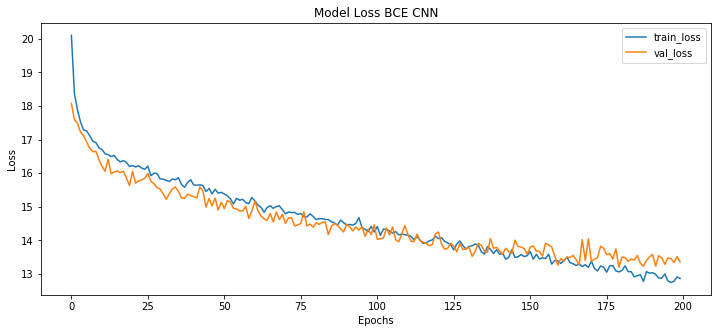

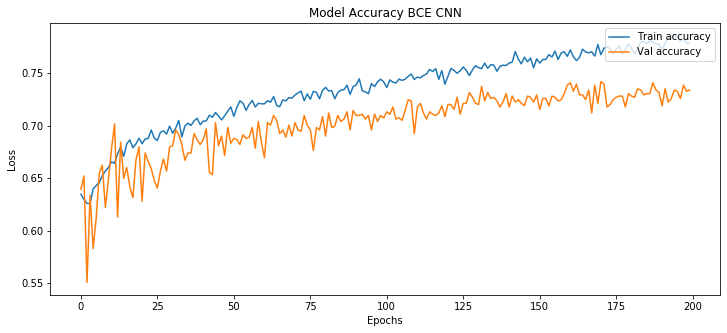

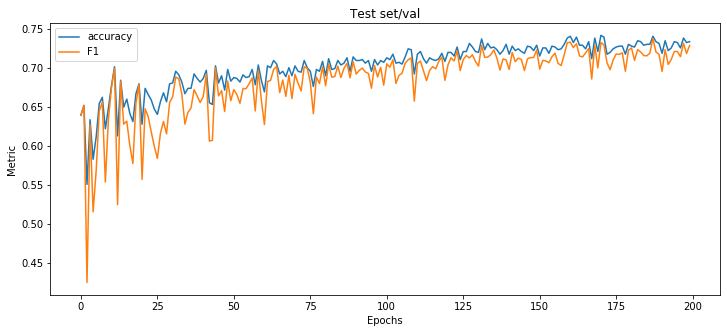

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.824261    0.850040  0.836952     0.783107  0.759996   
Confirmed            0.704114    0.663189  0.683039     0.783107  0.759996   

                F1 micro  
False Positive  0.784672  
Confirmed       0.784672

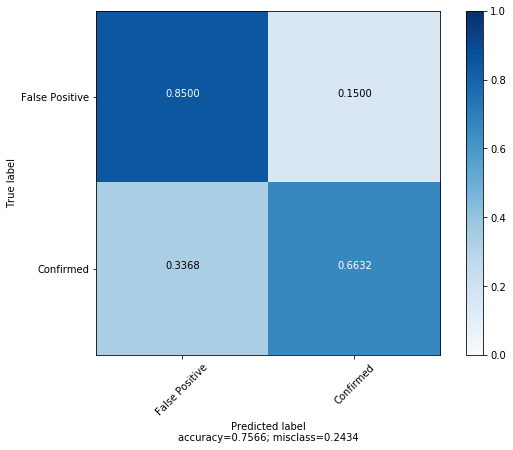

{'Precision raw': array([0.82426128, 0.70411392]),
 'Recall raw': array([0.8500401 , 0.66318927]),
 'F1 raw': array([0.83695223, 0.68303914]),
 'F1 weighted': 0.7831067230150288,
 'F1 macro': 0.7599956855008894,
 'F1 micro': 0.7846715328467153,
 'Confusion Matrix': array([[1060,  187],
        [ 226,  445]])}

In [22]:
#factor 0.2 y pat 10
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128*2, focal=True, alpha=0.5)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

## Hyperkeras para decisiones
* Batch size
* alpha
* Factor lr decay y patience

In [13]:
def data():
    """
    Data providing function:

    This function is separated from create_model() so that hyperopt
    won't reload data for each evaluation run.
    """
    channel_1 = np.load('/work/work_teamEXOPLANET/MTF_margarita/no_invertidos/MTF_u15_d15.npy')  
    channel_2 = np.load('/work/work_teamEXOPLANET/MTF_margarita/invertidos/MTF_u15_d15.npy')  
    channel_3 = np.load('/work/work_teamEXOPLANET/MTF_gabo/npys/time_channel_30.npy')  

    x_all = []
    for i in range(channel_1.shape[0]):
        combined_image = np.dstack((channel_1[i],channel_3[i]))
        x_all.append(combined_image)
    x_all = np.asarray(x_all)

    x_all2 = []
    for i in range(channel_1.shape[0]):
        combined_image = np.dstack((channel_2[i],channel_3[i]))
        x_all2.append(combined_image)
    x_all2 = np.asarray(x_all2)

    fold ="../../KOI_Data/"
    df_sets = pd.read_csv(fold+"/koi_sets.csv") 
    mask_train = (df_sets["Set"] == "Train").values
    mask_test = (df_sets["Set"] == "Test").values

    df_meta = pd.read_csv(fold+"/koi_metadata.csv")
    df_meta_train = df_meta[mask_train]
    df_meta_test = df_meta[mask_test]
    y_train= (df_meta_train['NExScI Disposition'].values=="CONFIRMED")*1
    y_val = (df_meta_test['NExScI Disposition'].values=="CONFIRMED")*1

    unique_train, counts_train = np.unique(y_train, return_counts=True)
    unique_val, counts_val = np.unique(y_val, return_counts=True)

    x_train1 = x_all[mask_train]
    x_train2 = x_all2[mask_train]
    x_train = np.concatenate([x_train1,x_train2]) #concat

    x_val = x_all[mask_test]

    if x_train.shape[0] != y_train.shape[0]:
        y_train = np.tile(y_train, (2))
    
    return x_train, y_train, x_val, y_val


import keras
from keras.layers import *
from keras.models import Sequential
from keras.utils import np_utils

from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

###### binary

In [22]:
def create_model(x_train, y_train, x_test, y_test):
    ####### PARA MEDIR F1 AL FINA LDE EPOCH ###########
    class Metrics(keras.callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.val_f1s = []

        def on_epoch_end(self, batch, logs={}):
            predict = np.squeeze(self.model.predict_classes(self.validation_data[0]))
            targ = np.squeeze(self.validation_data[1])
            f1s = f1_score(targ, predict, average='macro')
            self.val_f1s.append(f1s)
            #print(" - val_f1: %f " %(f1s))
            return
    def binary_focal_loss(gamma=2., alpha=.25):
        """
        Binary form of focal loss.
          FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
          where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
        References:
            https://arxiv.org/pdf/1708.02002.pdf
        Usage:
         model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
        """
        def binary_focal_loss_fixed(y_true, y_pred):
            """
            :param y_true: A tensor of the same shape as `y_pred`
            :param y_pred:  A tensor resulting from a sigmoid
            :return: Output tensor.
            """
            pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
            pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

            epsilon = K.epsilon()
            # clip to prevent NaN's and Inf's
            pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
            pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

            return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
                   -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

        return binary_focal_loss_fixed

    
    #elejir modelo?
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    
    #elejir global?
    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss=binary_focal_loss(alpha={{uniform(0.4,0.95)}}, 
                                         gamma={{choice([0.5, 1, 2 ,5])}}),
                                                optimizer="adam")
    #model.compile(loss='binary_crossentropy',optimizer='Adam')
    
    metrics = Metrics()
    result = model.fit(x_train, y_train,
                  batch_size={{choice([64, 128, 256 ,512])}},
                  epochs=200,
                  verbose=0,
                  validation_split=0.1, callbacks=[metrics])

    #get the highest validation accuracy of the training epochs
    validation_acc = np.amax(metrics.val_f1s) #np.amax(result.history['val_f1']) 
    print('Best validation metric of epoch:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}

>>> Imports:
#coding=utf-8

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    from scipy.stats import norm
except:
    pass

try:
    import itertools
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    from sklearn.metrics import mean_squared_error as mse
except:
    pass

try:
    from sklearn.utils import class_weight
except:
    pass

try:
    from astropy.io import fits
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import os, sys
except:
    pass

try:
    from sklearn.metrics import confusion_matrix, accuracy_score
except:
    pass

try:
    from keras.regularizers import l2
except:
    pass

try:
    from keras.activations import tanh
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import *
except:
    pass

try:
    from keras.losses import catego

  0%|          | 0/50 [00:00<?, ?it/s, best loss: ?]WARNING:tensorflow:From /opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Best validation metric of epoch:                    
0.7307570902482184                                  
  2%|▏         | 1/50 [06:01<4:55:18, 361.61s/it, best loss: -0.7307570902482184]

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Best validation metric of epoch:                                                 
0.6829661352471128                                                               
Best validation metric of epoch:                                                 
0.7694371397455309                                                               
Best validation metric of epoch:                                                 
0.7517738532679368                                                               
Best validation metric of epoch:                                                 
0.72010565675277                                                                 
Best validation metric of epoch:                                                 
0.7285968951640739                                                               
 12%|█▏        | 6/50 [41:08<4:48:01, 392.76s/it, best loss: -0.7694371397455309]

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Best validation metric of epoch:                                                 
0.7294619422572178                                                               
 14%|█▍        | 7/50 [46:57<4:32:00, 379.54s/it, best loss: -0.7694371397455309]

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Best validation metric of epoch:                                                 
0.734530245168543                                                                
 16%|█▌        | 8/50 [53:49<4:32:28, 389.25s/it, best loss: -0.7694371397455309]

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Best validation metric of epoch:                                                 
0.685321591532569                                                                  
Best validation metric of epoch:                                                   
0.7729592381440438                                                                 
Best validation metric of epoch:                                                    
0.7741827584193006                                                                  
Best validation metric of epoch:                                                    
0.7260127217944425                                                                  
Best validation metric of epoch:                                                    
0.7148437875857556                                                                  
Best validation metric of epoch:                                                    
0.7617501469479677                                                     

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Best validation metric of epoch:                                                    
0.7353596472712775                                                                  
Best validation metric of epoch:                                                    
0.7809508303484207                                                                  
Best validation metric of epoch:                                                    
0.6934752352529792                                                                  
Best validation metric of epoch:                                                    
0.698283466856854                                                                   
Best validation metric of epoch:                                                    
0.7490644338309252                                                                  
Best validation metric of epoch:                                                    
0.7624227852584916                                               

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Best validation metric of epoch:                                                    
0.7108289440946642                                                                  
Best validation metric of epoch:                                                    
0.7710477021890225                                                                  
Best validation metric of epoch:                                                    
0.7787971457696228                                                                  
Best validation metric of epoch:                                                    
0.7565165601124171                                                                  
 52%|█████▏    | 26/50 [2:51:05<2:44:03, 410.15s/it, best loss: -0.7809508303484207]

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Best validation metric of epoch:                                                    
0.757941437444543                                                                   
 54%|█████▍    | 27/50 [2:57:49<2:36:30, 408.28s/it, best loss: -0.7809508303484207]

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Best validation metric of epoch:                                                    
0.6940092165898618                                                                  
Best validation metric of epoch:                                                    
0.743786389362797                                                                   
Best validation metric of epoch:                                                    
0.7729543840081792                                                                  
Best validation metric of epoch:                                                    
0.766039289104875                                                                   
Best validation metric of epoch:                                                    
0.7681744073411172                                                                  
Best validation metric of epoch:                                                    
0.7588244600165648                                               

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Best validation metric of epoch:                                                    
0.7494320971666909                                                                  
Best validation metric of epoch:                                                    
0.7717682304946456                                                                  
 74%|███████▍  | 37/50 [4:06:12<1:31:06, 420.52s/it, best loss: -0.7809508303484207]

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Best validation metric of epoch:                                                    
0.6802054259238585                                                                  
 76%|███████▌  | 38/50 [4:12:15<1:20:37, 403.14s/it, best loss: -0.7809508303484207]

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Best validation metric of epoch:                                                    
0.7353596472712775                                                                  
Best validation metric of epoch:                                                    
0.7557551817872918                                                                  
 80%|████████  | 40/50 [4:24:50<1:04:29, 386.90s/it, best loss: -0.7809508303484207]

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Best validation metric of epoch:                                                    
0.6916275214147554                                                                  
Best validation metric of epoch:                                                    
0.7533024694268178                                                                
Best validation metric of epoch:                                                  
0.7293993075535987                                                                
Best validation metric of epoch:                                                  
0.7724490669405923                                                                
Best validation metric of epoch:                                                  
0.7486257389894113                                                                
Best validation metric of epoch:                                                  
0.7140268511654724                                                               

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Best validation metric of epoch:                                                  
0.7333420717395847                                                                
Best validation metric of epoch:                                                  
0.72010565675277                                                                  
Best validation metric of epoch:                                                  
0.7623067010309278                                                                
Best validation metric of epoch:                                                  
0.7683812254814106                                                                
100%|██████████| 50/50 [5:31:58<00:00, 398.80s/it, best loss: -0.7809508303484207]
{'alpha': 0.5023467327193865, 'batch_size': 1, 'gamma': 1}


Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.840097    0.829992  0.835014      0.78729  0.766807   
Confirmed            0.690962    0.706408  0.698600      0.78729  0.766807   

                F1 micro  
False Positive  0.786757  
Confirmed       0.786757

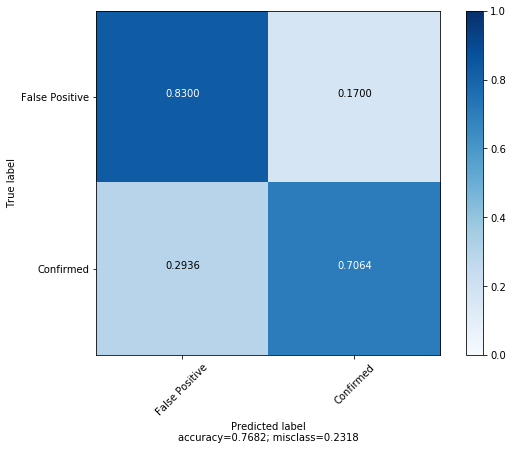

{'Precision raw': array([0.8400974, 0.6909621]),
 'Recall raw': array([0.82999198, 0.70640835]),
 'F1 raw': array([0.83501412, 0.69859985]),
 'F1 weighted': 0.7872904624582122,
 'F1 macro': 0.7668069856061365,
 'F1 micro': 0.7867570385818561,
 'Confusion Matrix': array([[1035,  212],
        [ 197,  474]])}

In [14]:
best_run, best_model = optim.minimize(model=create_model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=60,
                                          trials=Trials(),
                                     notebook_name='pruebas_cnn_MTF+T_fmena')
print(best_run)

x_train, y_train, x_val, y_val = data()

predichos=best_model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 32)        608       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1152)             

Epoch 92/500
7810/7810 [==============================] - 2s 227us/step - loss: 14.0817 - acc: 0.7533 - val_loss: 14.8084 - val_acc: 0.7143
 - val_f1: 0.684178 
Epoch 93/500
7810/7810 [==============================] - 2s 221us/step - loss: 13.9296 - acc: 0.7557 - val_loss: 14.5716 - val_acc: 0.7166
 - val_f1: 0.687700 
Epoch 94/500
7810/7810 [==============================] - 2s 223us/step - loss: 14.0595 - acc: 0.7535 - val_loss: 14.4502 - val_acc: 0.7154
 - val_f1: 0.691669 
Epoch 95/500
7810/7810 [==============================] - 2s 222us/step - loss: 14.0106 - acc: 0.7566 - val_loss: 14.2055 - val_acc: 0.7327
 - val_f1: 0.726193 
Epoch 96/500
7810/7810 [==============================] - 2s 224us/step - loss: 13.9537 - acc: 0.7633 - val_loss: 14.8119 - val_acc: 0.7189
 - val_f1: 0.688284 
Epoch 97/500
7810/7810 [==============================] - 2s 227us/step - loss: 13.8382 - acc: 0.7599 - val_loss: 14.6501 - val_acc: 0.7200
 - val_f1: 0.694054 
Epoch 98/500
7810/7810 [==========

 - val_f1: 0.722781 
Epoch 143/500
7810/7810 [==============================] - 2s 231us/step - loss: 12.9776 - acc: 0.7785 - val_loss: 13.8161 - val_acc: 0.7316
 - val_f1: 0.713671 
Epoch 144/500
7810/7810 [==============================] - 2s 229us/step - loss: 12.9254 - acc: 0.7822 - val_loss: 13.3637 - val_acc: 0.7500
 - val_f1: 0.736423 
Epoch 145/500
7810/7810 [==============================] - 2s 229us/step - loss: 12.9205 - acc: 0.7794 - val_loss: 13.7406 - val_acc: 0.7419
 - val_f1: 0.728948 
Epoch 146/500
7810/7810 [==============================] - 2s 231us/step - loss: 12.9907 - acc: 0.7802 - val_loss: 13.2158 - val_acc: 0.7650
 - val_f1: 0.756923 
Epoch 147/500
7810/7810 [==============================] - 2s 227us/step - loss: 13.0544 - acc: 0.7746 - val_loss: 13.4139 - val_acc: 0.7477
 - val_f1: 0.729866 
Epoch 148/500
7810/7810 [==============================] - 2s 222us/step - loss: 12.9793 - acc: 0.7807 - val_loss: 13.1344 - val_acc: 0.7673
 - val_f1: 0.758666 
Epoch 1

 - val_f1: 0.754155 
Epoch 244/500
7810/7810 [==============================] - 2s 231us/step - loss: 11.8314 - acc: 0.8040 - val_loss: 13.0892 - val_acc: 0.7696
 - val_f1: 0.759938 
Epoch 245/500
7810/7810 [==============================] - 2s 245us/step - loss: 11.9791 - acc: 0.8022 - val_loss: 13.1328 - val_acc: 0.7488
 - val_f1: 0.737562 
Epoch 246/500
7810/7810 [==============================] - 2s 242us/step - loss: 11.8003 - acc: 0.8077 - val_loss: 13.3382 - val_acc: 0.7523
 - val_f1: 0.743926 
Epoch 247/500
7810/7810 [==============================] - 2s 241us/step - loss: 11.9123 - acc: 0.8051 - val_loss: 13.7219 - val_acc: 0.7500
 - val_f1: 0.740628 
Epoch 248/500
7810/7810 [==============================] - 2s 241us/step - loss: 11.9083 - acc: 0.8077 - val_loss: 13.3444 - val_acc: 0.7477
 - val_f1: 0.734285 
Epoch 249/500
7810/7810 [==============================] - 2s 243us/step - loss: 11.6920 - acc: 0.8076 - val_loss: 13.3934 - val_acc: 0.7535
 - val_f1: 0.736531 
Epoch 2

 - val_f1: 0.724193 
Epoch 345/500
7810/7810 [==============================] - 2s 226us/step - loss: 10.6347 - acc: 0.8291 - val_loss: 14.1069 - val_acc: 0.7442
 - val_f1: 0.729900 
Epoch 346/500
7810/7810 [==============================] - 2s 229us/step - loss: 11.1243 - acc: 0.8222 - val_loss: 13.5378 - val_acc: 0.7488
 - val_f1: 0.739073 
Epoch 347/500
7810/7810 [==============================] - 2s 230us/step - loss: 10.6609 - acc: 0.8328 - val_loss: 13.7078 - val_acc: 0.7431
 - val_f1: 0.733456 
Epoch 348/500
7810/7810 [==============================] - 2s 236us/step - loss: 10.7967 - acc: 0.8286 - val_loss: 13.5311 - val_acc: 0.7558
 - val_f1: 0.745778 
Epoch 349/500
7810/7810 [==============================] - 2s 244us/step - loss: 10.7758 - acc: 0.8288 - val_loss: 13.3449 - val_acc: 0.7442
 - val_f1: 0.733532 
Epoch 350/500
7810/7810 [==============================] - 2s 245us/step - loss: 10.7953 - acc: 0.8256 - val_loss: 13.6080 - val_acc: 0.7419
 - val_f1: 0.728659 
Epoch 3

 - val_f1: 0.732202 
Epoch 446/500
7810/7810 [==============================] - 2s 228us/step - loss: 10.4689 - acc: 0.8429 - val_loss: 13.7838 - val_acc: 0.7327
 - val_f1: 0.718665 
Epoch 447/500
7810/7810 [==============================] - 2s 229us/step - loss: 10.3613 - acc: 0.8364 - val_loss: 13.2462 - val_acc: 0.7546
 - val_f1: 0.750067 
Epoch 448/500
7810/7810 [==============================] - 2s 231us/step - loss: 10.1820 - acc: 0.8452 - val_loss: 13.7904 - val_acc: 0.7431
 - val_f1: 0.736911 
Epoch 449/500
7810/7810 [==============================] - 2s 226us/step - loss: 10.2095 - acc: 0.8415 - val_loss: 13.7122 - val_acc: 0.7442
 - val_f1: 0.736367 
Epoch 450/500
7810/7810 [==============================] - 2s 227us/step - loss: 10.0729 - acc: 0.8439 - val_loss: 13.4542 - val_acc: 0.7477
 - val_f1: 0.739822 
Epoch 451/500
7810/7810 [==============================] - 2s 224us/step - loss: 10.1086 - acc: 0.8419 - val_loss: 13.5685 - val_acc: 0.7500
 - val_f1: 0.744706 
Epoch 4

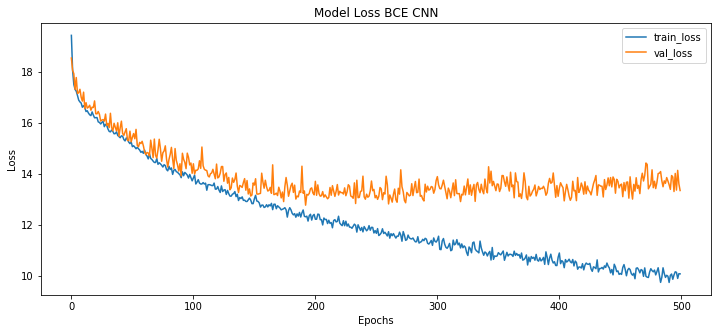

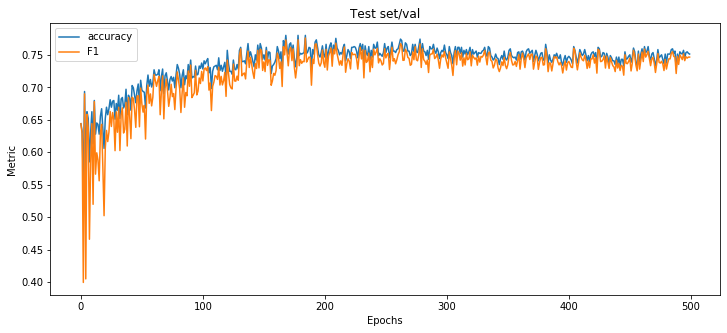

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.834783    0.846832  0.840764     0.790779  0.769325   
Confirmed            0.707504    0.688525  0.697885     0.790779  0.769325   

                F1 micro  
False Positive  0.791449  
Confirmed       0.791449

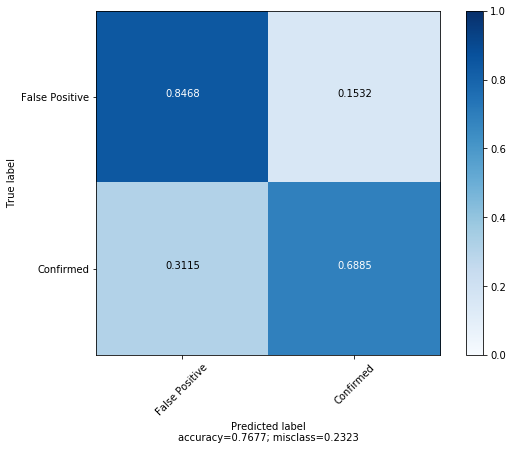

{'Precision raw': array([0.83478261, 0.70750383]),
 'Recall raw': array([0.8468324 , 0.68852459]),
 'F1 raw': array([0.84076433, 0.6978852 ]),
 'F1 weighted': 0.7907789821618769,
 'F1 macro': 0.7693247637924067,
 'F1 micro': 0.7914494264859229,
 'Confusion Matrix': array([[1056,  191],
        [ 209,  462]])}

In [17]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss=binary_focal_loss(alpha=0.5, gamma=1),optimizer='Adam',metrics=['accuracy'])
metrics = Metrics()
mcp_save = ModelCheckpoint('best_mod.hdf5', save_best_only=True, monitor='val_loss', mode='min')
hist=model.fit(x_train, y_train, batch_size=128, epochs=500, verbose=1, validation_split=0.1,#validation_data=(x_val,y_val),
                  callbacks=[metrics,mcp_save])
    
plt.figure(figsize=(12,5))
plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(hist.history['val_acc'],label="accuracy" )
plt.plot(metrics.val_f1s,label="F1" )
plt.ylabel("Metric")
plt.xlabel('Epochs')
plt.title("Test set/val")
plt.legend(loc="upper left")
plt.show()
   
keras.losses.binary_focal_loss_fixed = keras.losses.mse
best_model = keras.models.load_model("best_mod.hdf5")
predichos=best_model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')

###### lr decay

In [16]:
def create_model(x_train, y_train, x_test, y_test):
    ####### PARA MEDIR F1 AL FINA LDE EPOCH ###########
    class Metrics(keras.callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.val_f1s = []

        def on_epoch_end(self, batch, logs={}):
            predict = np.squeeze(self.model.predict_classes(self.validation_data[0]))
            targ = np.squeeze(self.validation_data[1])
            f1s = f1_score(targ, predict, average='macro')
            self.val_f1s.append(f1s)
            #print(" - val_f1: %f " %(f1s))
            return
    #elejir modelo?
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    
    #elejir global?
    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',optimizer='Adam')
    
    metrics = Metrics()
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode ='min',
                                  factor={{uniform(0.01,0.5)}},
                                  patience={{choice([5,10,15,20])}}, min_lr=0.001)
    result = model.fit(x_train, y_train,
                  batch_size={{choice([64, 128, 256 ,512])}},
                  epochs=200,
                  verbose=0,
                  validation_split=0.1, callbacks=[metrics, reduce_lr])

    #get the highest validation accuracy of the training epochs
    validation_acc = np.amax(metrics.val_f1s) #np.amax(result.history['val_f1']) 
    print('Best validation metric of epoch:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}

>>> Imports:
#coding=utf-8

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    from scipy.stats import norm
except:
    pass

try:
    import itertools
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    from sklearn.metrics import mean_squared_error as mse
except:
    pass

try:
    from sklearn.utils import class_weight
except:
    pass

try:
    from astropy.io import fits
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import os, sys
except:
    pass

try:
    from sklearn.metrics import confusion_matrix, accuracy_score
except:
    pass

try:
    from keras.regularizers import l2
except:
    pass

try:
    from keras.activations import tanh
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import *
except:
    pass

try:
    from keras.losses import catego

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Best validation metric of epoch:                                                 
0.7604517948614392                                                               
  6%|▌         | 2/35 [24:32<5:41:39, 621.18s/it, best loss: -0.7604517948614392]

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Best validation metric of epoch:                                                 
0.7668902845504626                                                               
Best validation metric of epoch:                                                 
0.7438026887698372                                                               
 11%|█▏        | 4/35 [49:27<5:41:17, 660.58s/it, best loss: -0.7668902845504626]

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Best validation metric of epoch:                                                 
0.7532244437058779                                                               
 14%|█▍        | 5/35 [56:57<4:58:35, 597.18s/it, best loss: -0.7668902845504626]

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Best validation metric of epoch:                                                 
0.7557773109243697                                                                 
 17%|█▋        | 6/35 [1:04:57<4:31:41, 562.13s/it, best loss: -0.7668902845504626]

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Best validation metric of epoch:                                                   
0.7285595154494382                                                                 
Best validation metric of epoch:                                                   
0.747251431432739                                                                  
 23%|██▎       | 8/35 [1:22:10<4:03:12, 540.44s/it, best loss: -0.7668902845504626]

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Best validation metric of epoch:                                                   
0.724600037643516                                                                  
 26%|██▌       | 9/35 [1:30:39<3:50:03, 530.91s/it, best loss: -0.7668902845504626]

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Best validation metric of epoch:                                                   
0.7219883703944925                                                                 
 29%|██▊       | 10/35 [1:38:57<3:37:08, 521.12s/it, best loss: -0.7668902845504626]

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Best validation metric of epoch:                                                    
0.7473953786159129                                                                  
 31%|███▏      | 11/35 [1:47:19<3:26:04, 515.17s/it, best loss: -0.7668902845504626]

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Best validation metric of epoch:                                                    
0.7251051893408136                                                                  
 34%|███▍      | 12/35 [1:55:22<3:13:48, 505.57s/it, best loss: -0.7668902845504626]

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Best validation metric of epoch:                                                    
0.7370044540903018                                                                  
Best validation metric of epoch:                                                    
0.7493849582543326                                                                  
 40%|████      | 14/35 [2:12:30<2:59:14, 512.10s/it, best loss: -0.7668902845504626]

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Best validation metric of epoch:                                                    
0.7388730411986226                                                                  
Best validation metric of epoch:                                                    
0.7367835843525725                                                                  
 46%|████▌     | 16/35 [2:29:54<2:44:27, 519.34s/it, best loss: -0.7668902845504626]

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Best validation metric of epoch:                                                    
0.7267884814049588                                                                  
Best validation metric of epoch:                                                    
0.7763958574424152                                                                  
 51%|█████▏    | 18/35 [2:45:49<2:20:26, 495.69s/it, best loss: -0.7763958574424152]

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Best validation metric of epoch:                                                    
0.7292056635469163                                                                  
Best validation metric of epoch:                                                    
0.7756293070826692                                                                  
Best validation metric of epoch:                                                    
0.7556090255835495                                                                  
Best validation metric of epoch:                                                    
0.7589852294814403                                                                  
Best validation metric of epoch:                                                    
0.7551871856956602                                                                  
Best validation metric of epoch:                                                    
0.7559622037233977                                               

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Best validation metric of epoch:                                                  
0.7625910580334172                                                                
Best validation metric of epoch:                                                  
0.7468855749733825                                                                
Best validation metric of epoch:                                                  
0.7613365930962556                                                                
 89%|████████▊ | 31/35 [4:24:16<30:26, 456.66s/it, best loss: -0.7763958574424152]

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Best validation metric of epoch:                                                  
0.7777208706786171                                                                
Best validation metric of epoch:                                                  
0.7498653394523086                                                                
Best validation metric of epoch:                                                  
0.7439115974680828                                                                
Best validation metric of epoch:                                                  
0.7624930092004928                                                                
100%|██████████| 35/35 [4:54:17<00:00, 453.28s/it, best loss: -0.7777208706786171]
{'batch_size': 0, 'factor': 0.2680243839977747, 'patience': 3}


Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.794097    0.906175  0.846442     0.777148  0.747406   
Confirmed            0.763636    0.563338  0.648370     0.777148  0.747406   

                F1 micro  
False Positive  0.786236  
Confirmed       0.786236

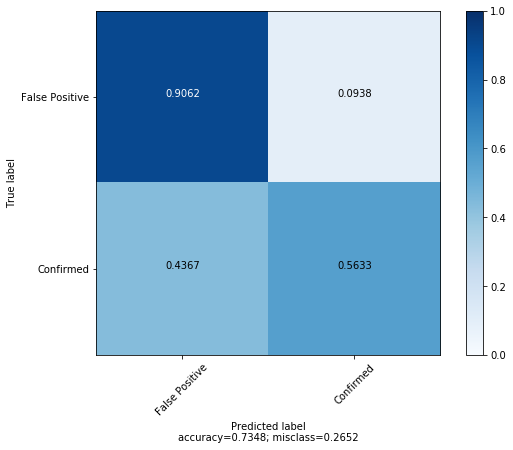

{'Precision raw': array([0.79409698, 0.76363636]),
 'Recall raw': array([0.90617482, 0.5633383 ]),
 'F1 raw': array([0.84644195, 0.6483705 ]),
 'F1 weighted': 0.7771479209529807,
 'F1 macro': 0.747406222496322,
 'F1 micro': 0.786235662148071,
 'Confusion Matrix': array([[1130,  117],
        [ 293,  378]])}

In [17]:
best_run, best_model = optim.minimize(model=create_model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=35,
                                          trials=Trials(),
                                     notebook_name='pruebas_cnn_MTF+T_fmena')
print(best_run)

x_train, y_train, x_val, y_val = data()

predichos=best_model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 32)        608       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)             

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


7810/7810 [==============================] - 2s 231us/step - loss: 0.5414 - acc: 0.6437 - val_loss: 0.5580 - val_acc: 0.6774
 - val_f1: 0.677281 
Epoch 4/500
7810/7810 [==============================] - 2s 231us/step - loss: 0.5401 - acc: 0.6391 - val_loss: 0.5586 - val_acc: 0.6601
 - val_f1: 0.652703 
Epoch 5/500
7810/7810 [==============================] - 2s 231us/step - loss: 0.5328 - acc: 0.6517 - val_loss: 0.5526 - val_acc: 0.6624
 - val_f1: 0.654575 
Epoch 6/500
7810/7810 [==============================] - 2s 233us/step - loss: 0.5300 - acc: 0.6469 - val_loss: 0.5557 - val_acc: 0.6175
 - val_f1: 0.536977 
Epoch 7/500
7810/7810 [==============================] - 2s 252us/step - loss: 0.5261 - acc: 0.6580 - val_loss: 0.5435 - val_acc: 0.6463
 - val_f1: 0.628710 
Epoch 8/500
7810/7810 [==============================] - 2s 236us/step - loss: 0.5221 - acc: 0.6682 - val_loss: 0.5383 - val_acc: 0.6417
 - val_f1: 0.614395 
Epoch 9/500
7810/7810 [==============================] - 2s 230u

 - val_f1: 0.697869 
Epoch 55/500
7810/7810 [==============================] - 2s 258us/step - loss: 0.4727 - acc: 0.7163 - val_loss: 0.4852 - val_acc: 0.6993
 - val_f1: 0.680803 
Epoch 56/500
7810/7810 [==============================] - 2s 253us/step - loss: 0.4670 - acc: 0.7245 - val_loss: 0.4816 - val_acc: 0.7074
 - val_f1: 0.702237 
Epoch 57/500
7810/7810 [==============================] - 2s 258us/step - loss: 0.4728 - acc: 0.7187 - val_loss: 0.4833 - val_acc: 0.7016
 - val_f1: 0.690426 
Epoch 58/500
7810/7810 [==============================] - 2s 257us/step - loss: 0.4679 - acc: 0.7188 - val_loss: 0.4816 - val_acc: 0.7039
 - val_f1: 0.693368 
Epoch 59/500
7810/7810 [==============================] - 2s 254us/step - loss: 0.4719 - acc: 0.7228 - val_loss: 0.4755 - val_acc: 0.7131
 - val_f1: 0.705805 
Epoch 60/500
7810/7810 [==============================] - 2s 260us/step - loss: 0.4681 - acc: 0.7202 - val_loss: 0.4759 - val_acc: 0.7131
 - val_f1: 0.708008 
Epoch 61/500
7810/7810 [=

7810/7810 [==============================] - 2s 260us/step - loss: 0.4066 - acc: 0.7770 - val_loss: 0.4413 - val_acc: 0.7235
 - val_f1: 0.708325 
Epoch 158/500
7810/7810 [==============================] - 2s 258us/step - loss: 0.4055 - acc: 0.7777 - val_loss: 0.4467 - val_acc: 0.7373
 - val_f1: 0.723214 
Epoch 159/500
7810/7810 [==============================] - 2s 258us/step - loss: 0.4004 - acc: 0.7821 - val_loss: 0.4425 - val_acc: 0.7293
 - val_f1: 0.714243 
Epoch 160/500
7810/7810 [==============================] - 2s 259us/step - loss: 0.4006 - acc: 0.7855 - val_loss: 0.4446 - val_acc: 0.7362
 - val_f1: 0.717531 
Epoch 161/500
7810/7810 [==============================] - 2s 261us/step - loss: 0.4065 - acc: 0.7772 - val_loss: 0.4521 - val_acc: 0.7350
 - val_f1: 0.713482 
Epoch 162/500
7810/7810 [==============================] - 2s 255us/step - loss: 0.4051 - acc: 0.7793 - val_loss: 0.4397 - val_acc: 0.7465
 - val_f1: 0.727760 
Epoch 163/500
7810/7810 [=============================

7810/7810 [==============================] - 2s 300us/step - loss: 0.3677 - acc: 0.8040 - val_loss: 0.4226 - val_acc: 0.7684
 - val_f1: 0.763203 
Epoch 260/500
7810/7810 [==============================] - 2s 298us/step - loss: 0.3729 - acc: 0.8009 - val_loss: 0.4417 - val_acc: 0.7512
 - val_f1: 0.743907 
Epoch 261/500
7810/7810 [==============================] - 2s 307us/step - loss: 0.3686 - acc: 0.8045 - val_loss: 0.4336 - val_acc: 0.7661
 - val_f1: 0.762656 
Epoch 262/500
7810/7810 [==============================] - 2s 303us/step - loss: 0.3653 - acc: 0.8083 - val_loss: 0.4348 - val_acc: 0.7500
 - val_f1: 0.739658 
Epoch 263/500
7810/7810 [==============================] - 2s 296us/step - loss: 0.3697 - acc: 0.8019 - val_loss: 0.4366 - val_acc: 0.7488
 - val_f1: 0.741117 
Epoch 264/500
7810/7810 [==============================] - 2s 305us/step - loss: 0.3807 - acc: 0.7988 - val_loss: 0.4273 - val_acc: 0.7684
 - val_f1: 0.758854 
Epoch 265/500
7810/7810 [=============================

7810/7810 [==============================] - 2s 301us/step - loss: 0.3551 - acc: 0.8183 - val_loss: 0.4225 - val_acc: 0.7742
 - val_f1: 0.771397 
Epoch 362/500
7810/7810 [==============================] - 2s 299us/step - loss: 0.3424 - acc: 0.8232 - val_loss: 0.4198 - val_acc: 0.7684
 - val_f1: 0.764860 
Epoch 363/500
7810/7810 [==============================] - 2s 290us/step - loss: 0.3422 - acc: 0.8246 - val_loss: 0.4208 - val_acc: 0.7673
 - val_f1: 0.765844 
Epoch 364/500
7810/7810 [==============================] - 2s 289us/step - loss: 0.3321 - acc: 0.8307 - val_loss: 0.4447 - val_acc: 0.7488
 - val_f1: 0.744596 
Epoch 365/500
7810/7810 [==============================] - 2s 292us/step - loss: 0.3336 - acc: 0.8325 - val_loss: 0.4383 - val_acc: 0.7581
 - val_f1: 0.755193 
Epoch 366/500
7810/7810 [==============================] - 2s 291us/step - loss: 0.3369 - acc: 0.8292 - val_loss: 0.4380 - val_acc: 0.7500
 - val_f1: 0.745211 
Epoch 367/500
7810/7810 [=============================

7810/7810 [==============================] - 2s 287us/step - loss: 0.3270 - acc: 0.8389 - val_loss: 0.4308 - val_acc: 0.7627
 - val_f1: 0.761608 
Epoch 464/500
7810/7810 [==============================] - 2s 281us/step - loss: 0.3128 - acc: 0.8434 - val_loss: 0.4310 - val_acc: 0.7661
 - val_f1: 0.760332 
Epoch 465/500
7810/7810 [==============================] - 2s 287us/step - loss: 0.3162 - acc: 0.8412 - val_loss: 0.4530 - val_acc: 0.7569
 - val_f1: 0.748251 
Epoch 466/500
7810/7810 [==============================] - 2s 277us/step - loss: 0.3261 - acc: 0.8379 - val_loss: 0.4189 - val_acc: 0.7673
 - val_f1: 0.764637 
Epoch 467/500
7810/7810 [==============================] - 2s 277us/step - loss: 0.3279 - acc: 0.8360 - val_loss: 0.4311 - val_acc: 0.7627
 - val_f1: 0.758357 
Epoch 468/500
7810/7810 [==============================] - 2s 284us/step - loss: 0.3247 - acc: 0.8360 - val_loss: 0.4340 - val_acc: 0.7661
 - val_f1: 0.764075 
Epoch 469/500
7810/7810 [=============================

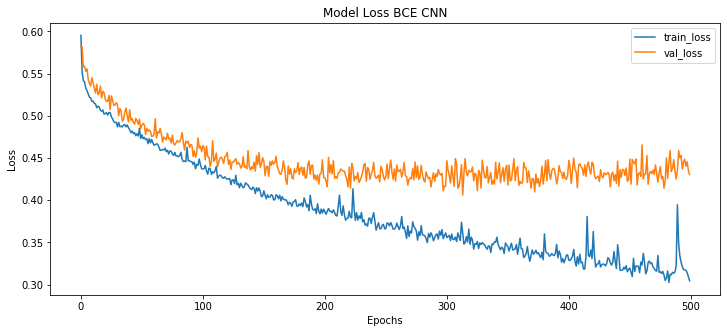

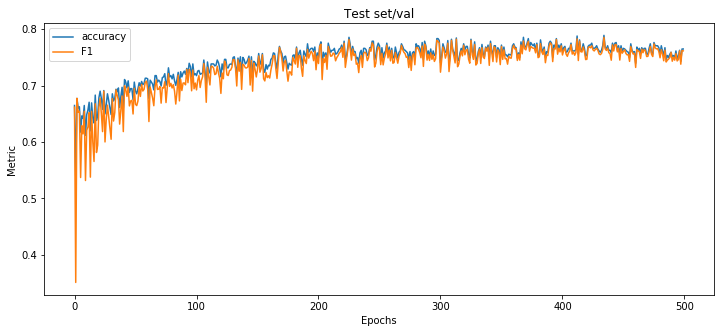

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.845248    0.805934  0.825123      0.77985  0.760419   
Confirmed            0.668038    0.725782  0.695714      0.77985  0.760419   

                F1 micro  
False Positive  0.777894  
Confirmed       0.777894

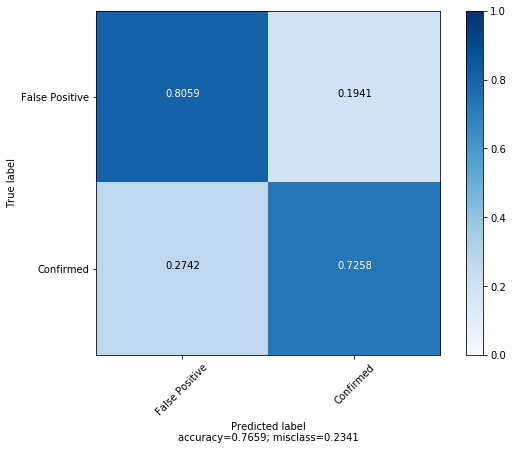

{'Precision raw': array([0.84524811, 0.66803841]),
 'Recall raw': array([0.80593424, 0.72578241]),
 'F1 raw': array([0.82512315, 0.69571429]),
 'F1 weighted': 0.779850290481156,
 'F1 macro': 0.7604187192118226,
 'F1 micro': 0.7778936392075079,
 'Confusion Matrix': array([[1005,  242],
        [ 184,  487]])}

In [16]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
metrics = Metrics()
mcp_save = ModelCheckpoint('best_mod.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode ='min',factor=0.27,patience=20, min_lr=0.001)
hist=model.fit(x_train, y_train, batch_size=64, epochs=500, verbose=1, validation_split=0.1,#validation_data=(x_val,y_val),
                  callbacks=[metrics,mcp_save,reduce_lr])
    
plt.figure(figsize=(12,5))
plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(hist.history['val_acc'],label="accuracy" )
plt.plot(metrics.val_f1s,label="F1" )
plt.ylabel("Metric")
plt.xlabel('Epochs')
plt.title("Test set/val")
plt.legend(loc="upper left")
plt.show()
    

best_model = keras.models.load_model("best_mod.hdf5")
predichos=best_model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')